## Import Required Libraries

In [1]:
# ignore future warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pickle
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from deep_translator import GoogleTranslator
from deep_translator import MyMemoryTranslator

from tensorflow.keras import Sequential
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

## Load the data file

In [3]:
# set filepath for the data
data_file_path = '../data/'

# Load the data
df = pd.read_excel(data_file_path+'h22index-42.xlsx', header=1, skipfooter=6, na_values=[r'-', r'–', r'－'])
df.head()

Unnamed: 0   キャベツ  ねぎ     レタス  ばれいしょ  たまねぎ  きゅうり    トマト  ほうれんそう  にんじん  \
0   平成29年11月6日の週  171.0 NaN   763.0    NaN   NaN   NaN  783.0     NaN   NaN   
1  平成29年11月13日の週  198.0 NaN   909.0    NaN   NaN   NaN  771.0     NaN   NaN   
2  平成29年11月20日の週  196.0 NaN   873.0    NaN   NaN   NaN  757.0     NaN   NaN   
3  平成29年11月27日の週  207.0 NaN   969.0    NaN   NaN   NaN  762.0     NaN   NaN   
4   平成29年12月4日の週  221.0 NaN  1109.0    NaN   NaN   NaN  794.0     NaN   NaN   

    はくさい   だいこん  なす  
0  189.0  192.0 NaN  
1  195.0  190.0 NaN  
2  209.0  190.0 NaN  
3  236.0  204.0 NaN  
4  243.0  215.0 NaN

In [4]:
# verify only relevant data at the end of the dataframe
df.tail()

Unnamed: 0   キャベツ     ねぎ    レタス  ばれいしょ   たまねぎ   きゅうり    トマト  ほうれんそう  \
244   令和4年9月19日の週  141.0  854.0  580.0  380.0  311.0  591.0  867.0     NaN   
245   令和4年9月26日の週  157.0  855.0  560.0  375.0  303.0  602.0  878.0     NaN   
246   令和4年10月3日の週  162.0  814.0  545.0    NaN  298.0    NaN  897.0     NaN   
247  令和4年10月10日の週  173.0  791.0  556.0    NaN  291.0    NaN  913.0     NaN   
248  令和4年10月17日の週  167.0  785.0  533.0    NaN  283.0    NaN  910.0     NaN   

      にんじん   はくさい   だいこん  なす  
244  544.0    NaN    NaN NaN  
245  527.0    NaN    NaN NaN  
246  508.0  234.0  255.0 NaN  
247  480.0  239.0  251.0 NaN  
248  479.0  236.0  228.0 NaN

As seen from the above sample, the column names and the first column values are in `Japanese`.

Before proceeding any further, the `Japanese` text is first translated into `English`.

## Data Translation

In [5]:
# extract the column names and the contents of the `Unnamed: 0` column
orig_col_names = list(df.columns[1:])
first_col_vals = list(df['Unnamed: 0'])

# translate the column names and the `Unnamed: 0` column contents
translated_col_names = GoogleTranslator(source='ja', target='en').translate_batch(orig_col_names)
translated_col_vals = MyMemoryTranslator(source='ja-JP', target='en-GB').translate_batch(first_col_vals)

In [6]:
# view a sample of the translated column names
translated_col_names[1:7]

['green onion', 'lettuce', 'potato', 'onion', 'cucumber', 'tomato']

In [7]:
# view a sample of the translated first column values
translated_col_vals[1:4]

['Week of November 13, 2017',
 'Week of November 20, 2017',
 'Week of November 27, 2017']

Here, it is seen that each row in the dataset represents the weekly data.
- and the week starts on `Monday`.

In [8]:
# extract date string from the translated first column values
translated_col_vals = [date[8:] for date in translated_col_vals]

translated_col_vals[1:4]

['November 13, 2017', 'November 20, 2017', 'November 27, 2017']

In [9]:
# make all vegetable names to lower case
translated_col_names = [name.lower() for name in translated_col_names]

# add 'Date' as the column name for the first column
translated_col_names.insert(0, 'Date')


# replace the column names and `Unnamed: 0` column contents with translated text
df.columns = translated_col_names
df['Date'] = pd.to_datetime(translated_col_vals, format='%B %d, %Y')

df.head()

Date  cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
0 2017-11-06    171.0          NaN    763.0     NaN    NaN       NaN   783.0   
1 2017-11-13    198.0          NaN    909.0     NaN    NaN       NaN   771.0   
2 2017-11-20    196.0          NaN    873.0     NaN    NaN       NaN   757.0   
3 2017-11-27    207.0          NaN    969.0     NaN    NaN       NaN   762.0   
4 2017-12-04    221.0          NaN   1109.0     NaN    NaN       NaN   794.0   

   spinach  carrot  chinese cabbage  radish  eggplant  
0      NaN     NaN            189.0   192.0       NaN  
1      NaN     NaN            195.0   190.0       NaN  
2      NaN     NaN            209.0   190.0       NaN  
3      NaN     NaN            236.0   204.0       NaN  
4      NaN     NaN            243.0   215.0       NaN

In [10]:
df.tail()

Date  cabbage  green onion  lettuce  potato  onion  cucumber  \
244 2022-09-19    141.0        854.0    580.0   380.0  311.0     591.0   
245 2022-09-26    157.0        855.0    560.0   375.0  303.0     602.0   
246 2022-10-03    162.0        814.0    545.0     NaN  298.0       NaN   
247 2022-10-10    173.0        791.0    556.0     NaN  291.0       NaN   
248 2022-10-17    167.0        785.0    533.0     NaN  283.0       NaN   

     tomato  spinach  carrot  chinese cabbage  radish  eggplant  
244   867.0      NaN   544.0              NaN     NaN       NaN  
245   878.0      NaN   527.0              NaN     NaN       NaN  
246   897.0      NaN   508.0            234.0   255.0       NaN  
247   913.0      NaN   480.0            239.0   251.0       NaN  
248   910.0      NaN   479.0            236.0   228.0       NaN

Now, the `Date` column is made the index of the dataframe

In [11]:
# set the 'Date' column as the index
df.set_index(keys='Date', inplace=True)

df.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
Date                                                                         
2017-11-06    171.0          NaN    763.0     NaN    NaN       NaN   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       NaN   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       NaN   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       NaN   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       NaN   794.0   

            spinach  carrot  chinese cabbage  radish  eggplant  
Date                                                            
2017-11-06      NaN     NaN            189.0   192.0       NaN  
2017-11-13      NaN     NaN            195.0   190.0       NaN  
2017-11-20      NaN     NaN            209.0   190.0       NaN  
2017-11-27      NaN     NaN            236.0   204.0       NaN  
2017-12-04      NaN     NaN            243.0   215.0       NaN

In [12]:
# get shape of the dataframe
rows, vars = df.shape

print(f'We have {rows} records and {vars} number of independent variables.')

We have 249 records and 12 number of independent variables.


## Data Cleaning and Pre-processing

### Check Missing data
### i. check missing indexes

In [13]:
# check for missing dates in the index
missing_weeks = pd.date_range(start='2017-11-06', end='2022-10-17', freq='W-MON').difference(df.index)
print(f'The missing weeks in the dataset are:\n{missing_weeks}')

The missing weeks in the dataset are:
DatetimeIndex(['2018-01-01', '2018-04-30', '2018-12-31', '2019-04-29',
               '2019-12-30', '2020-05-04', '2020-12-28', '2021-05-03',
               '2021-12-27', '2022-05-02'],
              dtype='datetime64[ns]', freq=None)


### ii. check missing values

In [14]:
# check count of null values
df.isna().sum()

cabbage              2
green onion         72
lettuce              2
potato             125
onion               47
cucumber           126
tomato               2
spinach            199
carrot             146
chinese cabbage    125
radish             118
eggplant           200
dtype: int64

As seen, all the columns have missing values in varying degree.
- `eggplant` and `spinach` have 200 and 199 missing values out of 249 records respectively.
- `carrot` has about 146 missing values.
- `potato`, `cucumber`, `chinese cabbage`, and `radish` have about 125 missing values.

### iii. further explore the missing data

In [15]:
# check if any row has missing value for all columns
tmp_df = df[df.isnull().all(axis=1)]

tmp_df

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
Date                                                                         
2020-04-20      NaN          NaN      NaN     NaN    NaN       NaN     NaN   
2020-04-27      NaN          NaN      NaN     NaN    NaN       NaN     NaN   

            spinach  carrot  chinese cabbage  radish  eggplant  
Date                                                            
2020-04-20      NaN     NaN              NaN     NaN       NaN  
2020-04-27      NaN     NaN              NaN     NaN       NaN

For the weeks of $20^{th}$ and $27^{th}$ April 2020, all the vegetables have missing values.
- From the website of Japanese Ministry of Agriculture, Forestry and Fisheries, it can be found that:
  - No data was collected nationwide for these weeks.
- The same can be assumed for the above identified 10 weeks for which there are no records in the dataset.

Add these two weeks also to the `missing_weeks` list.

In [16]:
missing_weeks = missing_weeks.append(tmp_df.index)

missing_weeks

DatetimeIndex(['2018-01-01', '2018-04-30', '2018-12-31', '2019-04-29',
               '2019-12-30', '2020-05-04', '2020-12-28', '2021-05-03',
               '2021-12-27', '2022-05-02', '2020-04-20', '2020-04-27'],
              dtype='datetime64[ns]', freq=None)

In [17]:
# drop the 20th and 27th April indexes from the dataframe for now
df.drop(index=tmp_df.index, inplace=True)

<AxesSubplot:>

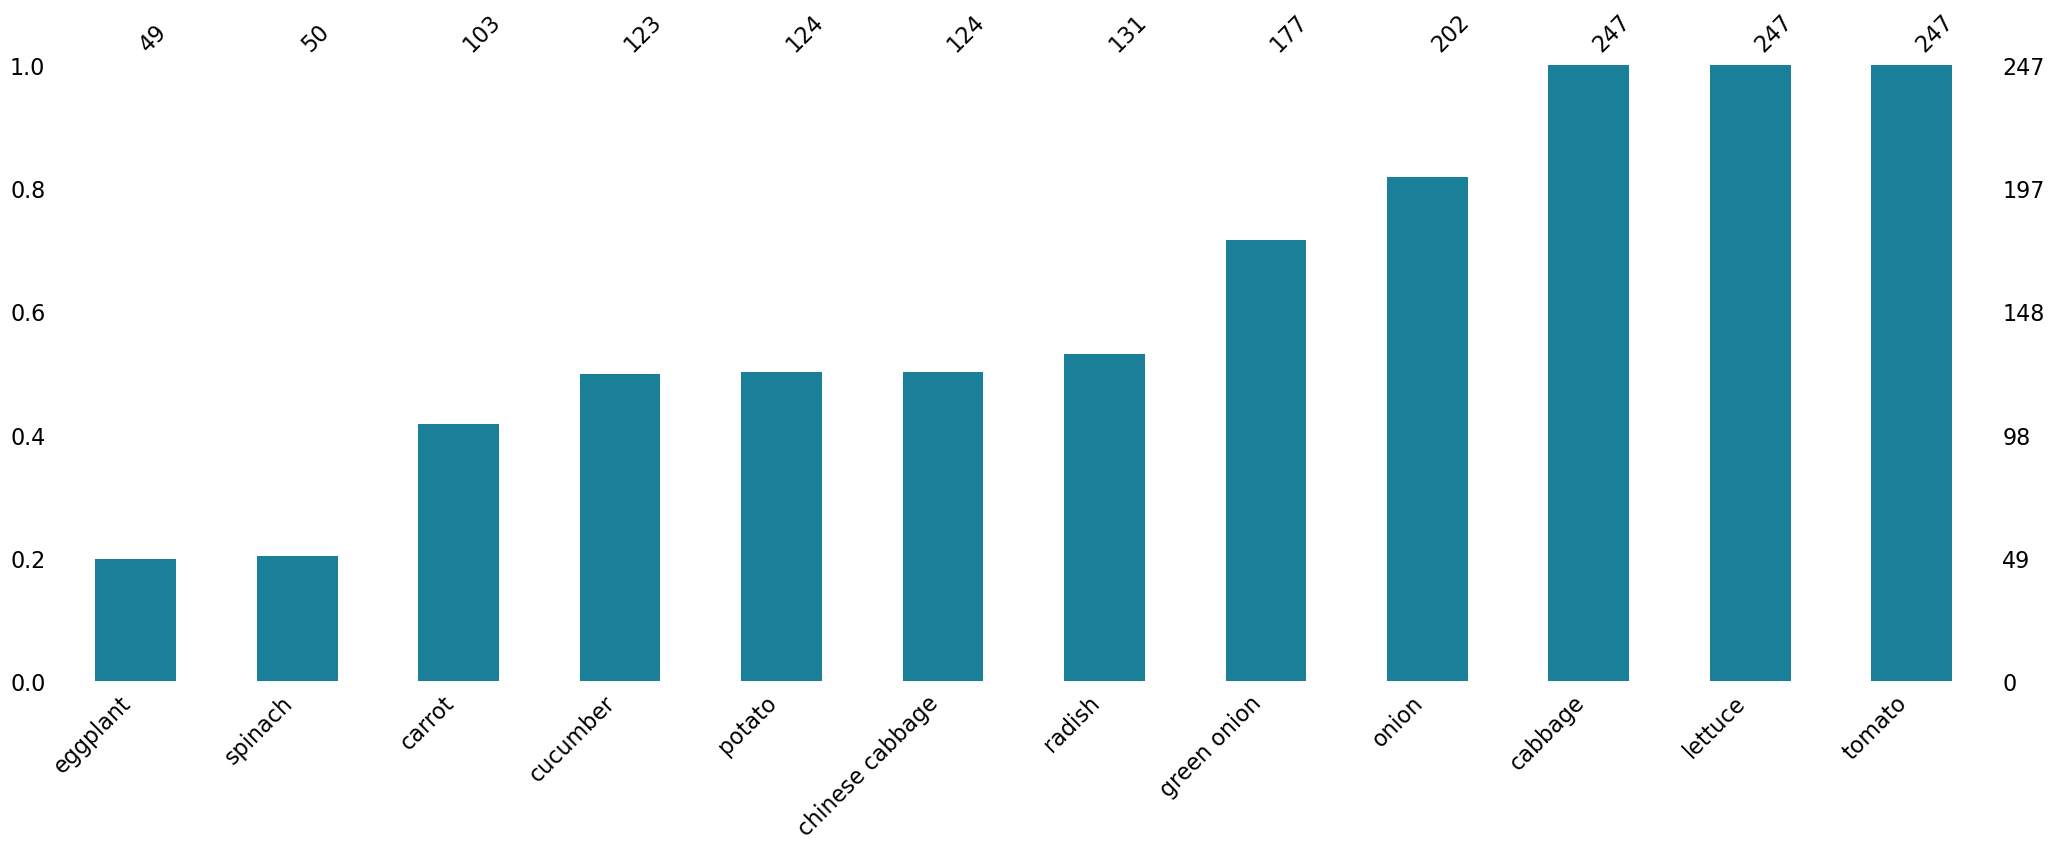

In [18]:
# visualise the count of missing data
msno.bar(df, figsize=(25,8), color=(0.1, 0.5, 0.6), sort='ascending')

From the above bar graph, following notable observations can be found:
1. `spinach` and `eggplant` have almost 80% of their data missing.
2. `potato`, `cucumber`, `carrot`, `chinese cabbage`, and `radish` have about 50-60% of their data missing.

<AxesSubplot:>

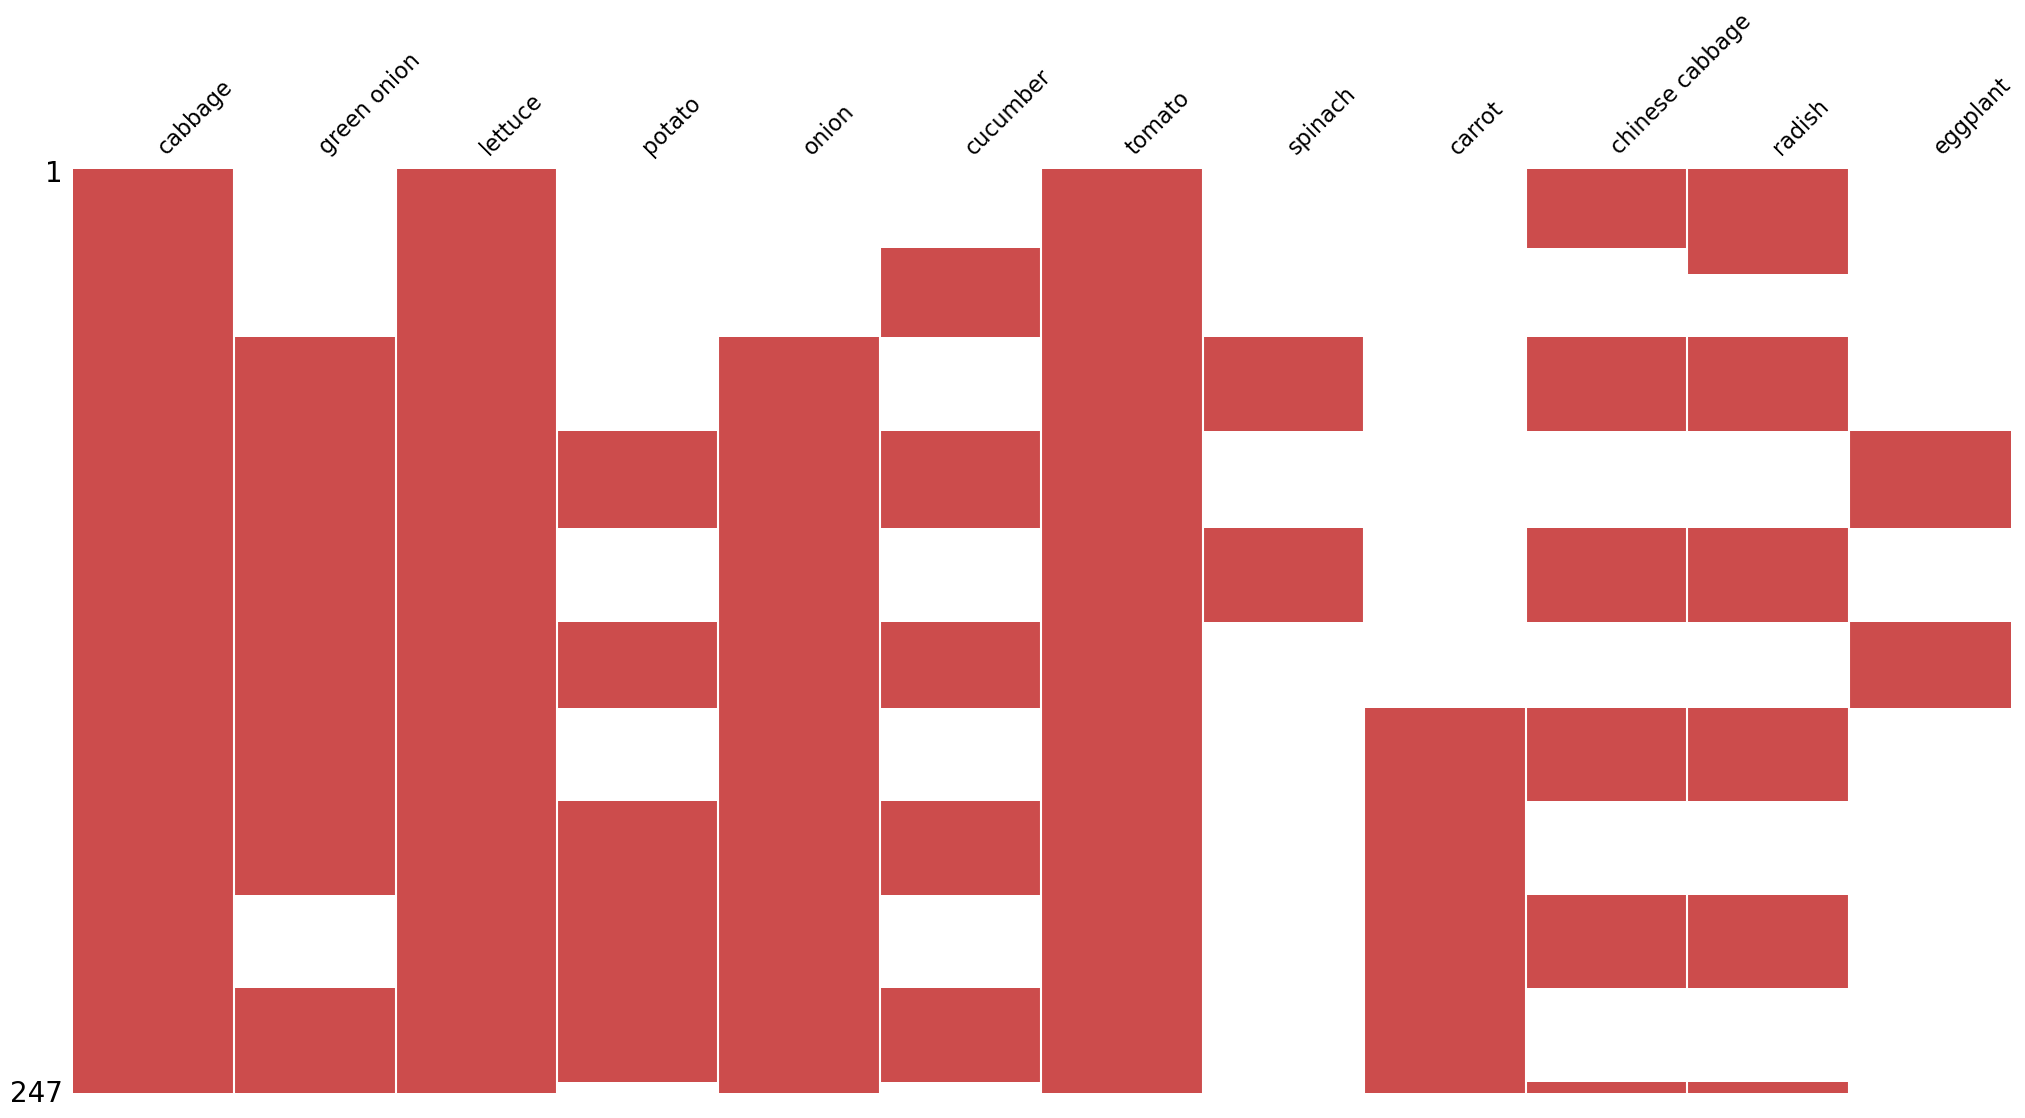

In [19]:
# visualise the pattern of missing values
msno.matrix(df, figsize=(25,12), color=(0.8, 0.3, 0.3), sparkline=False)

From the above matrix, following notable observations can be found:
1. `chinese cabbage`, `radish`, and `cucumber` seems to have seasonal pattern in its missing values.
2. `chinese cabbage`, and `radish` have missing data during opposite intervals compared to `cucumber`.
3. `green onion` and `onion` have missing data during the initial times.

<AxesSubplot:>

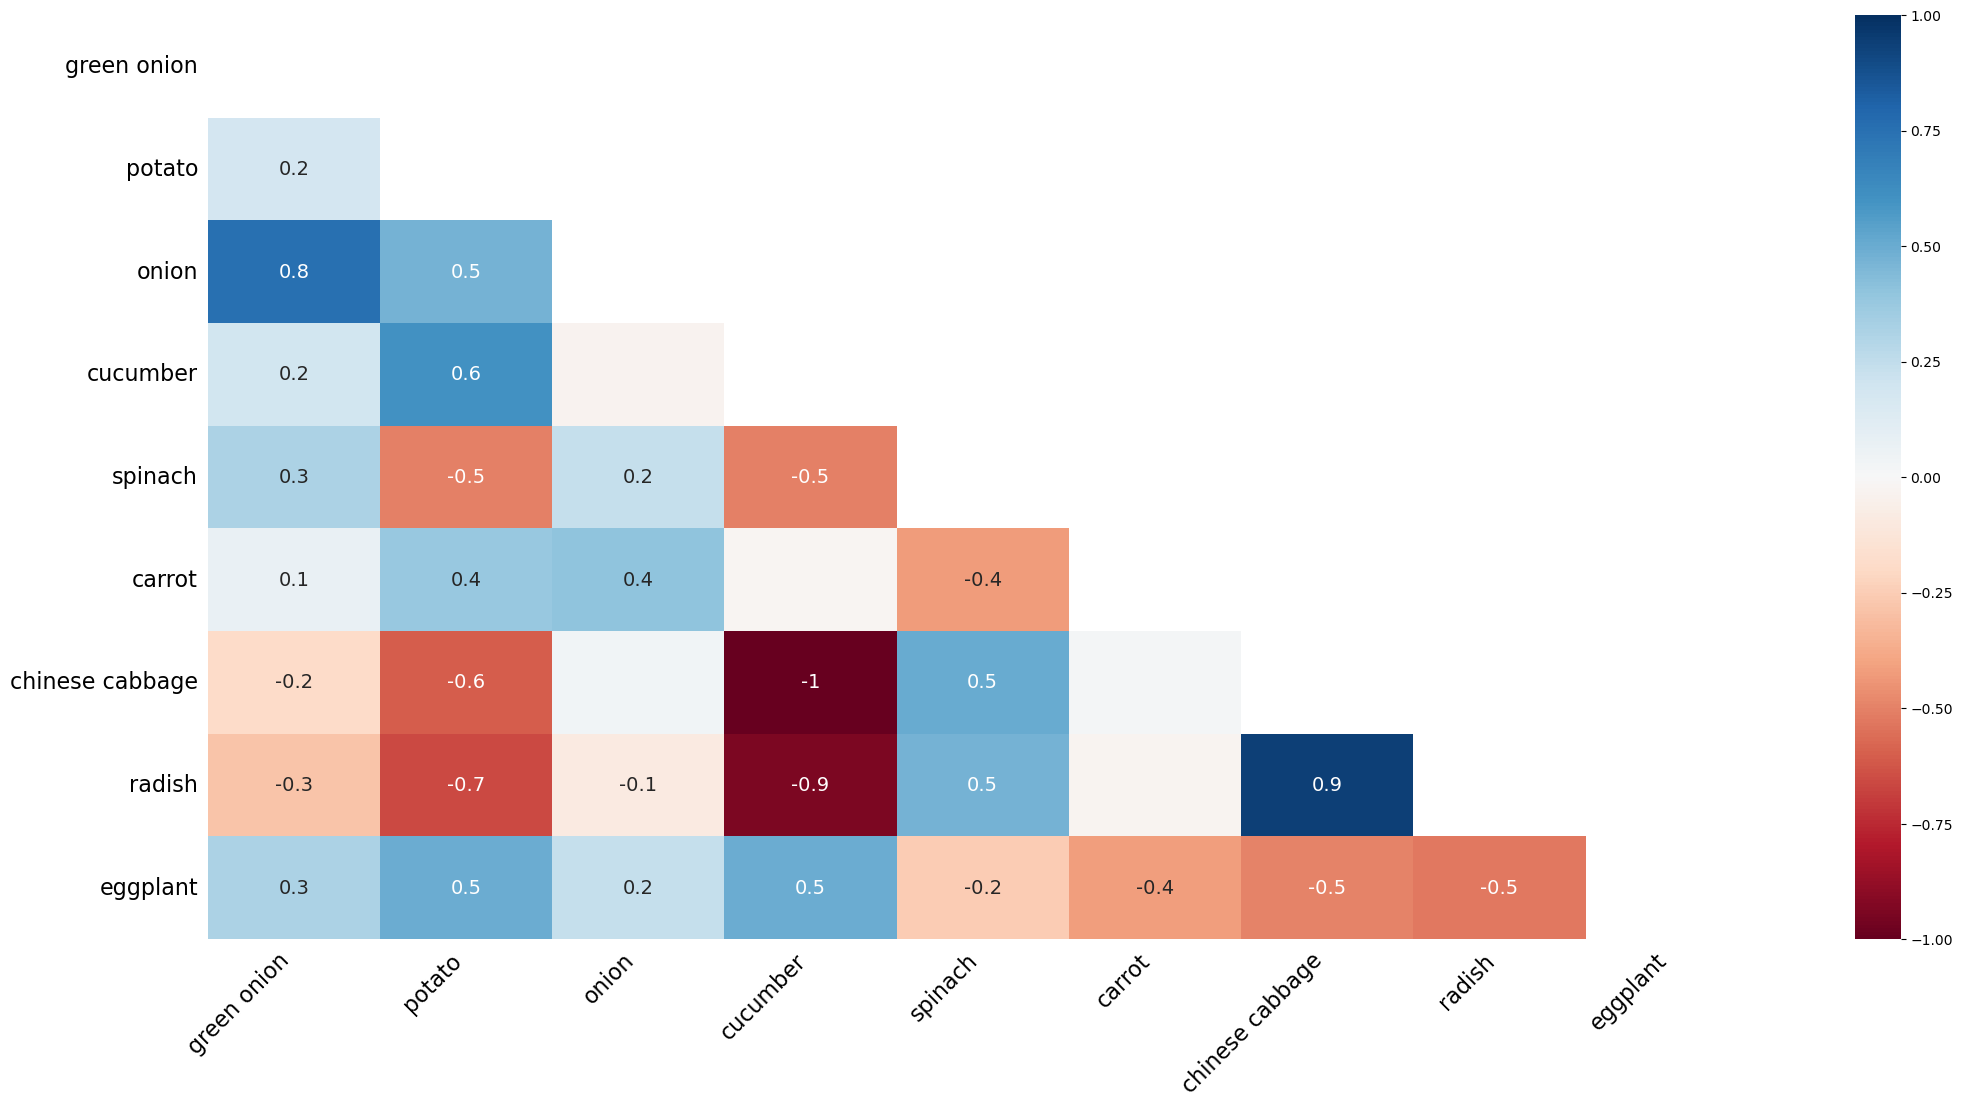

In [20]:
# visualise the correlation between the variables in terms of occurance of missing value
msno.heatmap(df, figsize=(25,12))

From the above correlation heatmap, following notable observations can be found:
1. `onion` and `green onion` have a nullity correlation of 0.8, indicating that for these two, the occurance of missing values are highly correlated.
2. `chinese cabbage` and `radish` have a nullity correlation of -1 and -0.9 with `cucumber` respectively, indicating that the occurance of missing values between them are highly correlated, but in negative order, i.e. when data for `cucumber` is available, it is not available for `chinese cabbage` and `radish`, and vice-versa. This could be due to seasonal nature of these vegetables.
3. `chinese cabbage` and `radish` also have a very high nullity correlation of almost 0.9.

### iv. Add the missing weeks

To maintain the continuity in the time series,
- the above identified missing weeks are added into the dataset with null values.
- and checked for patterns in missing data again.

In [21]:
# build a temporary dataframe with missing weeks as index
# and the same columns as the main dataset
tmp_df = pd.DataFrame(index=missing_weeks, columns=df.columns)

# concat this temporary dataframe to the main dataset
tmp_df = pd.concat([df, tmp_df])

# sort the dataframe according to the index
tmp_df.sort_index(inplace=True)

# set index to weekly period with 'Monday' as the starting day of the week
tmp_df.index.to_period('W-MON')         

tmp_df.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
2017-11-06    171.0          NaN    763.0     NaN    NaN       NaN   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       NaN   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       NaN   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       NaN   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       NaN   794.0   

            spinach  carrot  chinese cabbage  radish  eggplant  
2017-11-06      NaN     NaN            189.0   192.0       NaN  
2017-11-13      NaN     NaN            195.0   190.0       NaN  
2017-11-20      NaN     NaN            209.0   190.0       NaN  
2017-11-27      NaN     NaN            236.0   204.0       NaN  
2017-12-04      NaN     NaN            243.0   215.0       NaN

<AxesSubplot:>

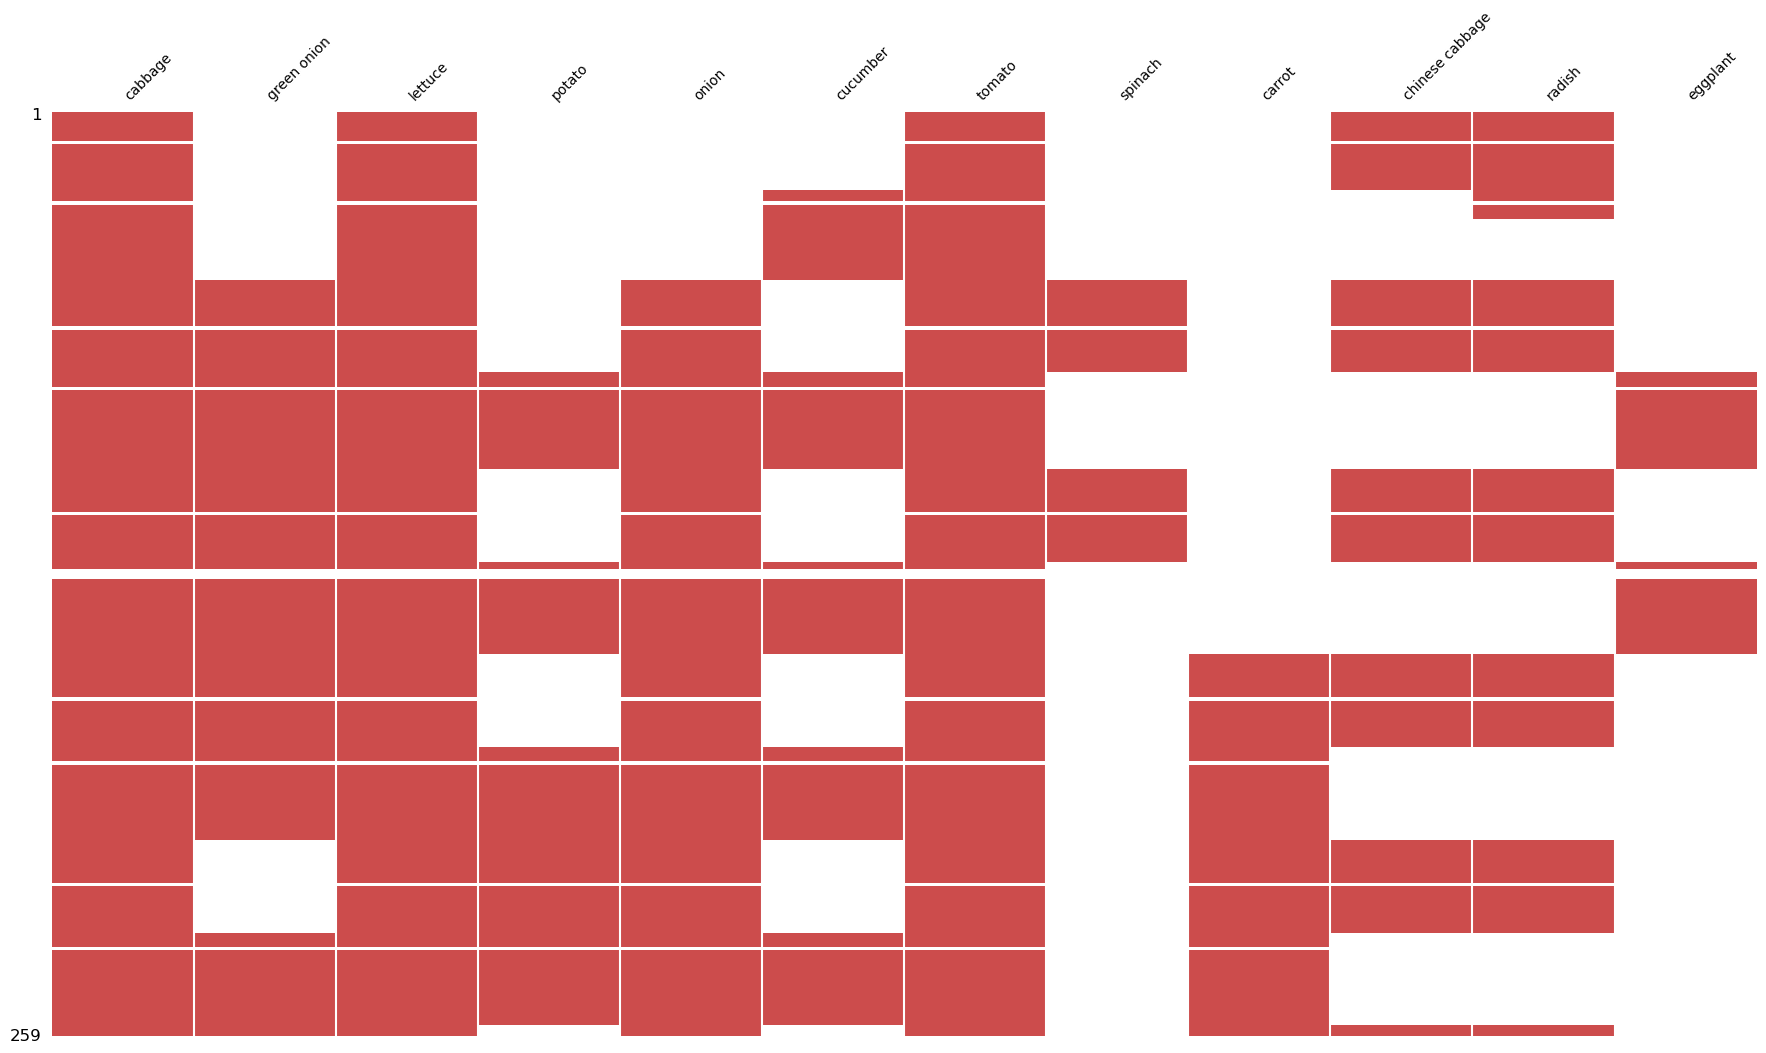

In [22]:
# visualise the pattern of missing data again after the addition of the missing weaks
msno.matrix(tmp_df, figsize=(22,12), color=(0.8, 0.3, 0.3), fontsize=10, sparkline=False)

From the above matrix, following observations can be found:
1. The missing weaks identified previously are randomly distributed across the whole dataset.

### Impute the Missing data

From the above exploration of the missing values and background research, the following insights into the missing values can be found:
1. `eggplant` and `spinach` has about 80% missing data, and `carrot` has about 60% missing data.
   - these three columns should be removed from our consideration owing to such high missing data in them.</br></br>
2. `chinese cabbage`, `radish` and `cucumber` have missing data but in a seasonal pattern
   - this indicates seasonality in the trend and hence this seasonal information must be kept in the dataset.
   - the period with seasonal missing values can be imputed with 0.</br></br>
3. No data was collected nationwide on 20th and 27th April 2020.
   - this maybe due to some restrictions implemented nationwide against corona.
   - similar plausible reasons could also be behind the missing data for the 10 weeks which were identified to be missing from the original dataset.
   - the values for these weeks can be imputed.

In [23]:
# remove columns with high missing values
df.drop(columns=['spinach', 'eggplant', 'carrot'], inplace=True)

df.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
Date                                                                         
2017-11-06    171.0          NaN    763.0     NaN    NaN       NaN   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       NaN   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       NaN   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       NaN   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       NaN   794.0   

            chinese cabbage  radish  
Date                                 
2017-11-06            189.0   192.0  
2017-11-13            195.0   190.0  
2017-11-20            209.0   190.0  
2017-11-27            236.0   204.0  
2017-12-04            243.0   215.0

In [24]:
# maintain an original copy of the dataset before imputing any values
df_copy = df.copy(deep=True)

# replace seasonal missing values in chinese cabbage, radish and cucumber to zero
df['chinese cabbage'].fillna(0, inplace=True)
df['radish'].fillna(0, inplace=True)
df['cucumber'].fillna(0, inplace=True)

df.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
Date                                                                         
2017-11-06    171.0          NaN    763.0     NaN    NaN       0.0   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       0.0   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       0.0   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       0.0   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       0.0   794.0   

            chinese cabbage  radish  
Date                                 
2017-11-06            189.0   192.0  
2017-11-13            195.0   190.0  
2017-11-20            209.0   190.0  
2017-11-27            236.0   204.0  
2017-12-04            243.0   215.0

In [25]:
# now concatenate the 12 missing weeks identified to the dataframe
# and interpolate the missing values for all the columns

# concat the temporary dataframe to the main dataset
tmp_df = pd.DataFrame(index=missing_weeks, columns=df.columns)
df = pd.concat([df, tmp_df])

# sort the dataframe according to the index
df.sort_index(inplace=True)

# set index to weekly period with 'Monday' as the starting day of the week
df.index.to_period('W-MON')       

df.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
2017-11-06    171.0          NaN    763.0     NaN    NaN       0.0   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       0.0   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       0.0   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       0.0   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       0.0   794.0   

            chinese cabbage  radish  
2017-11-06            189.0   192.0  
2017-11-13            195.0   190.0  
2017-11-20            209.0   190.0  
2017-11-27            236.0   204.0  
2017-12-04            243.0   215.0

In [26]:
# check dtypes of the dataframe columns
df.dtypes

cabbage            float64
green onion        float64
lettuce            float64
potato             float64
onion              float64
cucumber           float64
tomato             float64
chinese cabbage    float64
radish             float64
dtype: object

#### Data Exploration before Missing values Imputation 
Before imputing the missing values, let's first explore the data to identify proper imputation technique.

#### i. distribution of the variables

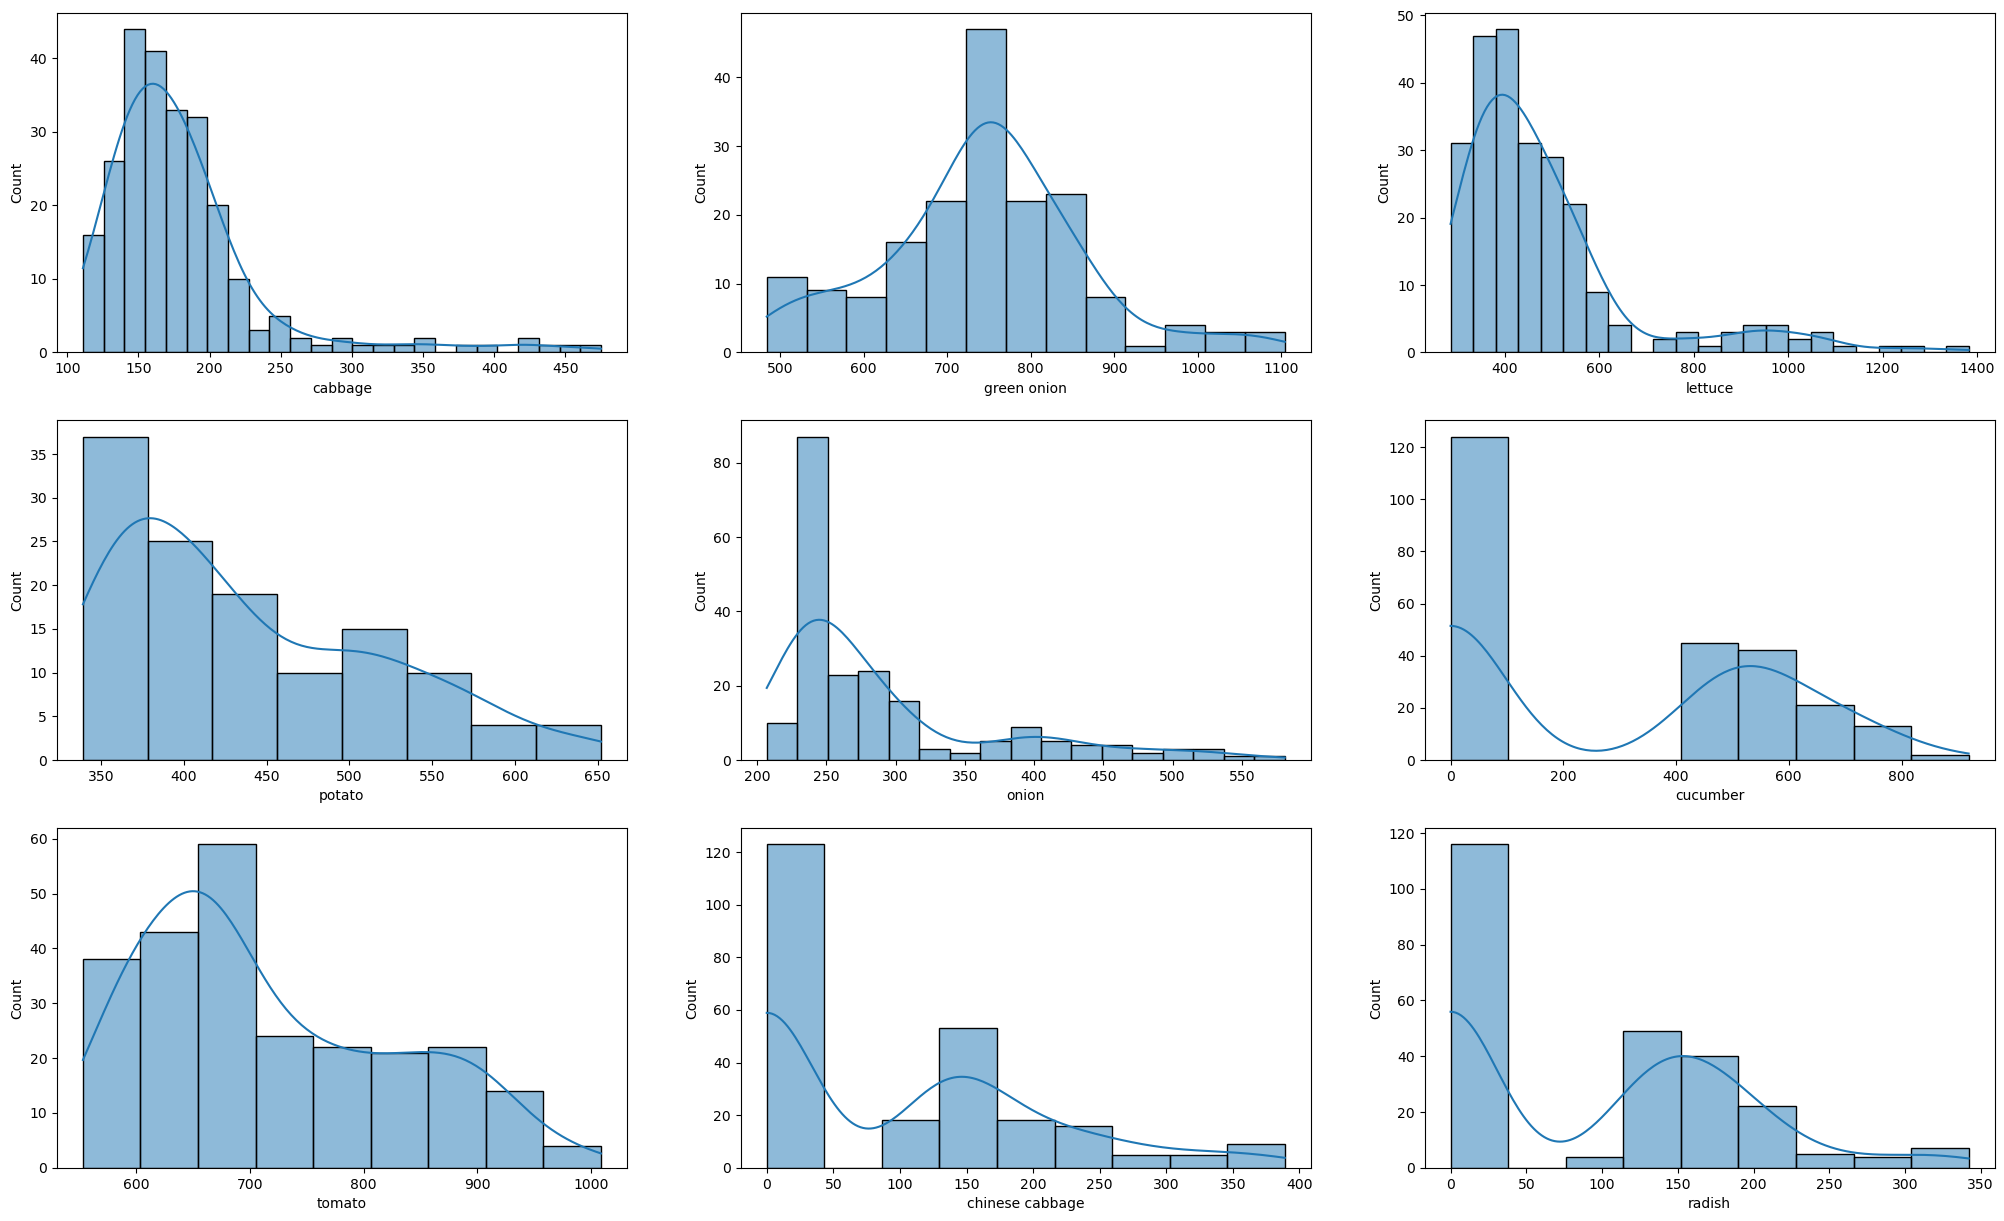

In [27]:
# define figure
plt.figure(figsize=(25,15))
idx = 1

# plot histogram for all the columns
for col_name in df.columns:
    plt.subplot(3, 3, idx)
    sns.histplot(data=df, x=col_name, kde=True)

    idx += 1

plt.show()

Major observations:
1. The plots have a right-skewed uniform distribution
2. `cucumber`, `chinese cabbage` and `radish` have a peak at zero also, as we had filled the seasonal missing values with `0`.

#### ii. boxplot

<AxesSubplot:>

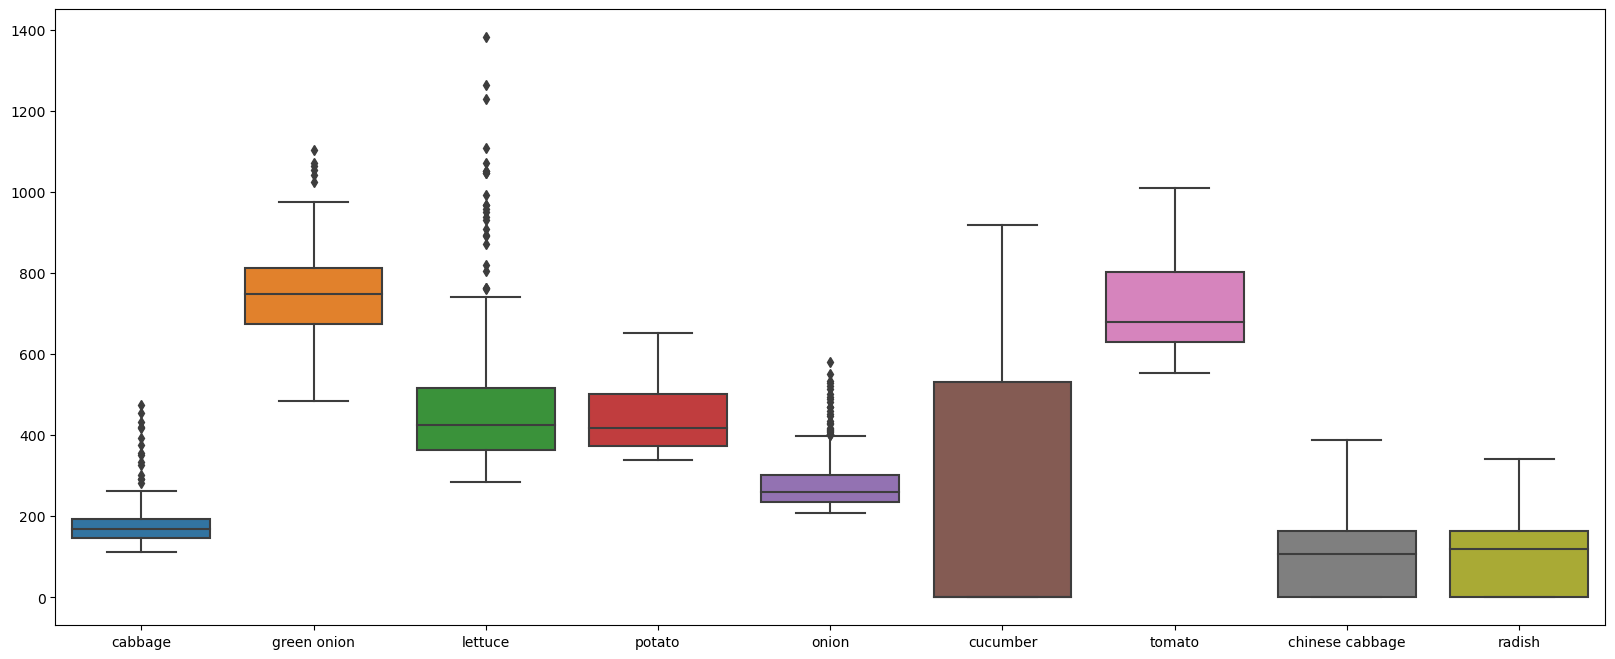

In [28]:
# define figure
plt.figure(figsize=(20,8))

# boxplot for all the columns
sns.boxplot(data=df)

**Major Observations:**
1. `cabbage`, `green onion`, `lettuce` and `onion` have global outliers.
2. `chinese cabbage` and `radish` have similar range of price.
3. Similarly `lettuce` and `potato` have similar range of price.

#### iii. price trend over time for all vegetables

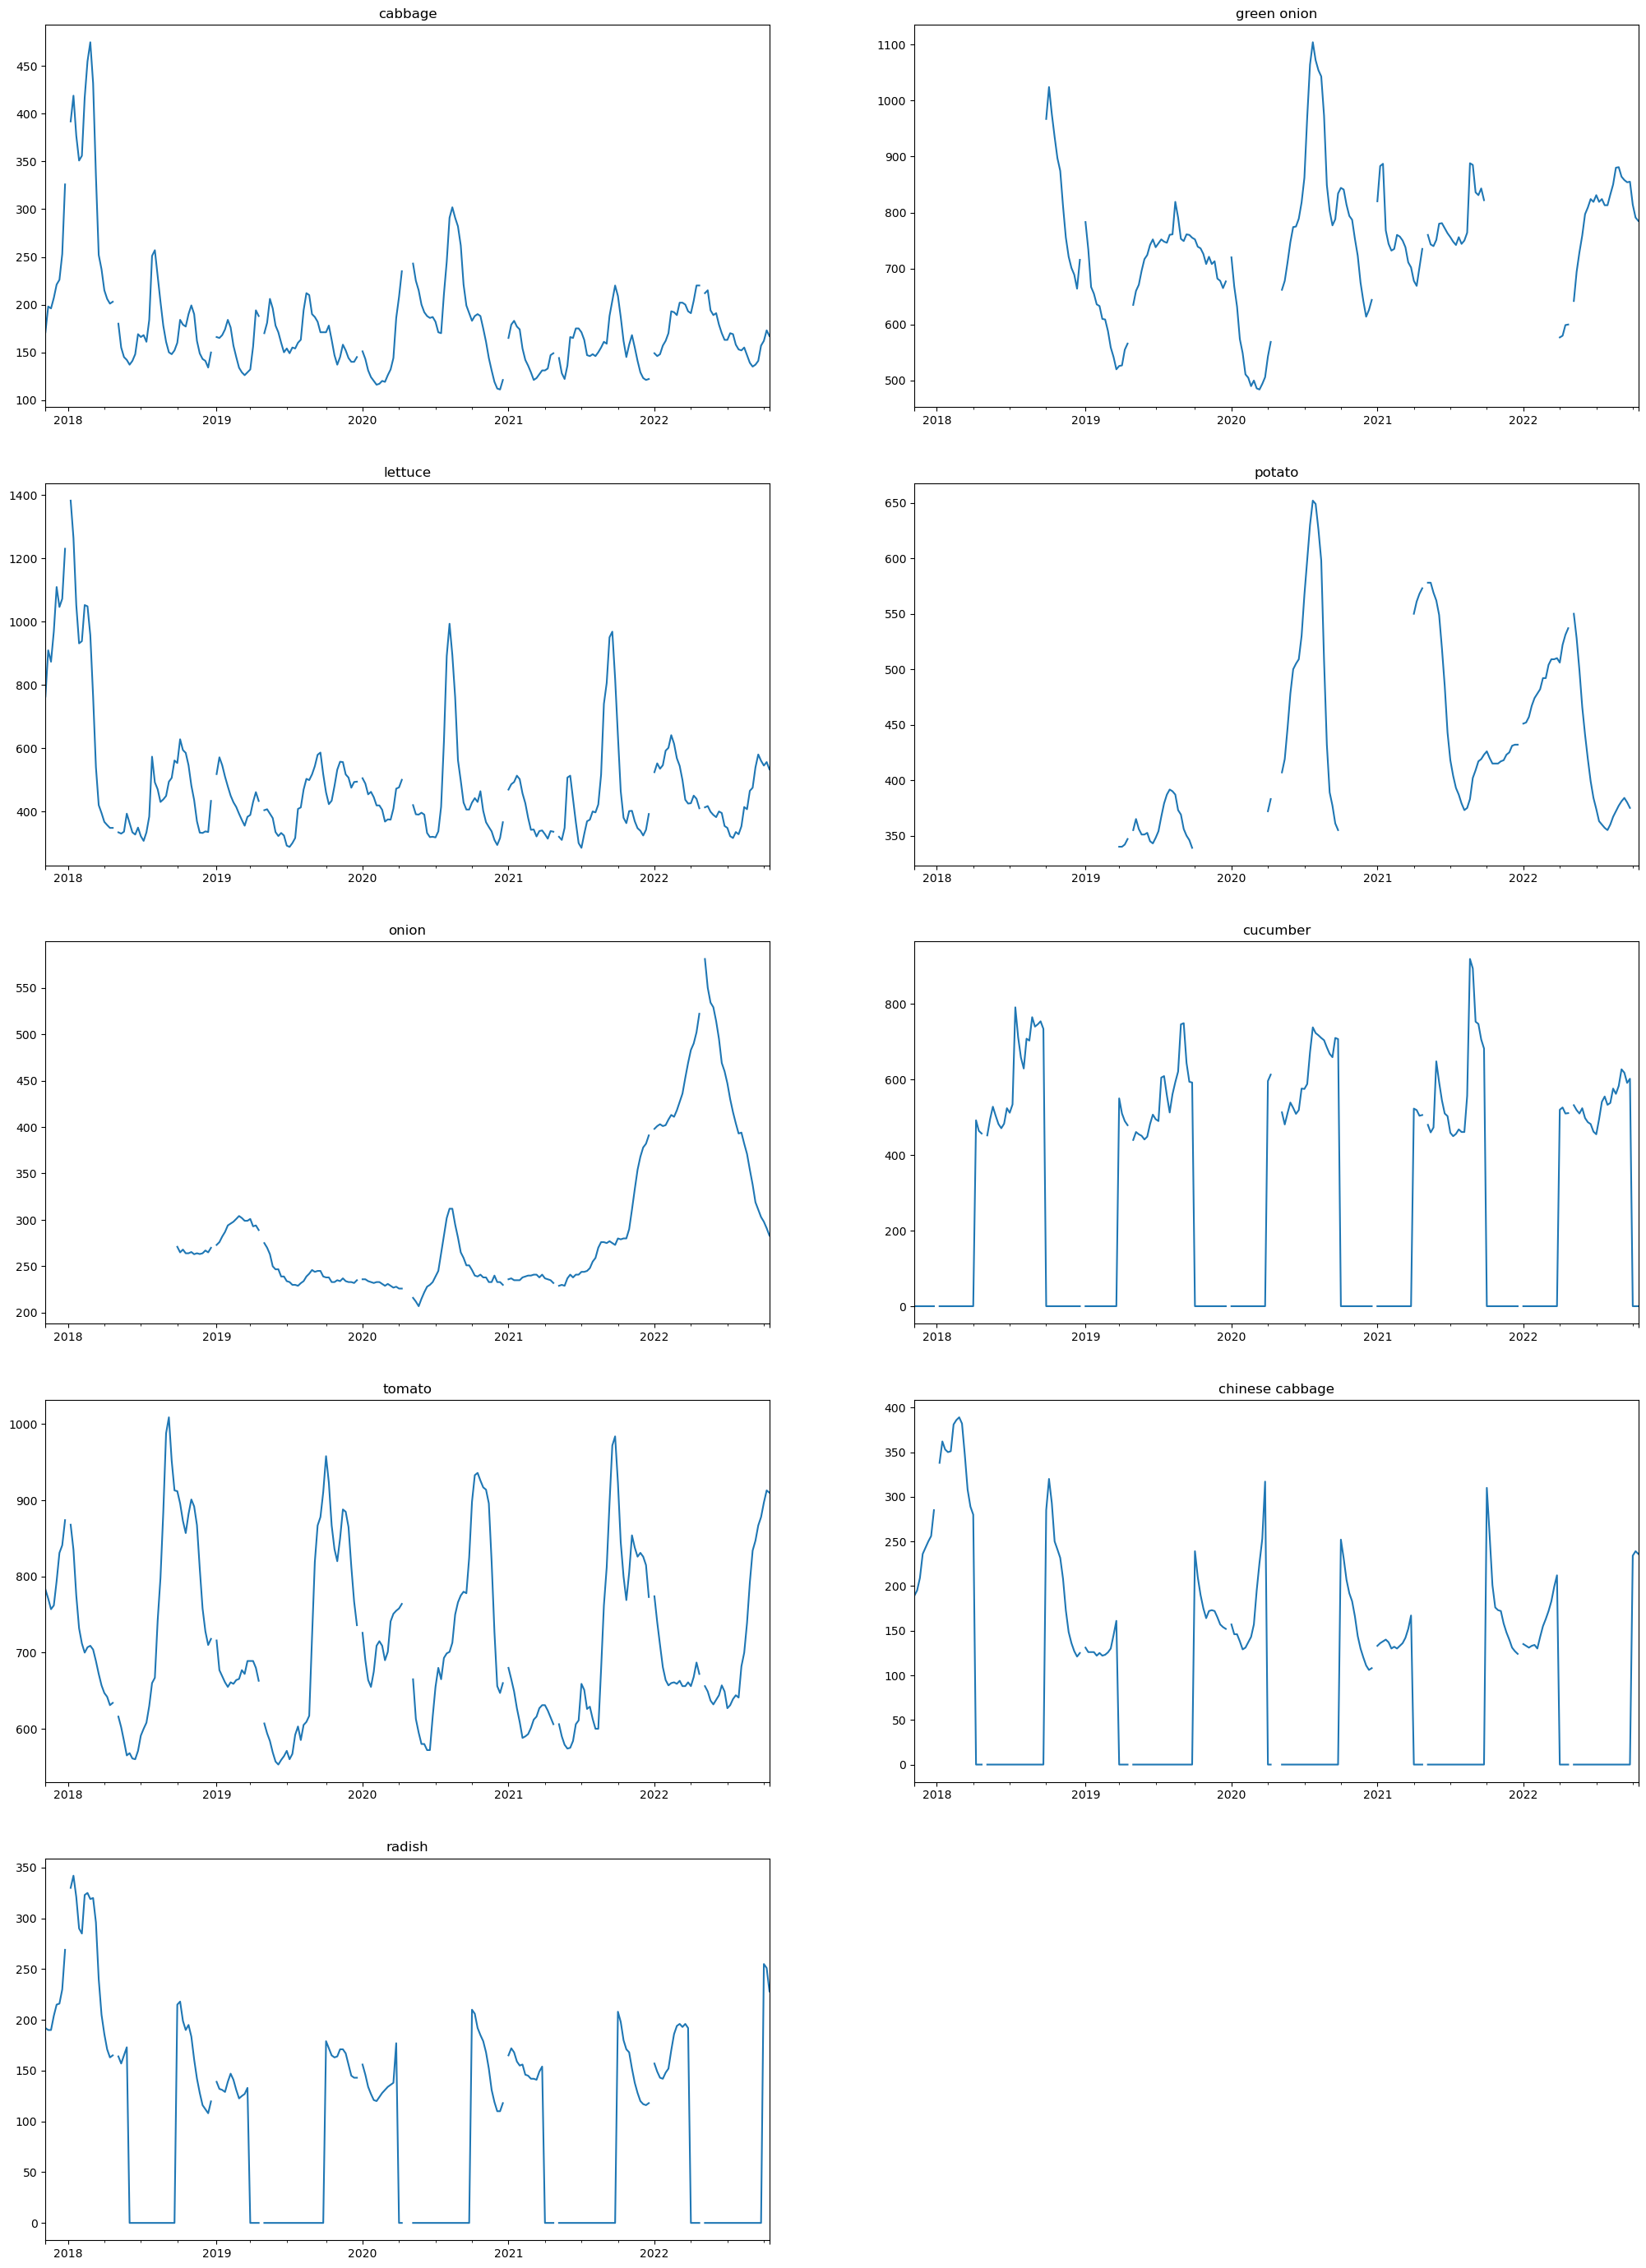

In [29]:
# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot histogram for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    df[col_name].plot()
    plt.title(col_name)

    idx += 1

plt.show()

#### iv. find correlation between the vegetables

<Figure size 1000x1000 with 0 Axes>

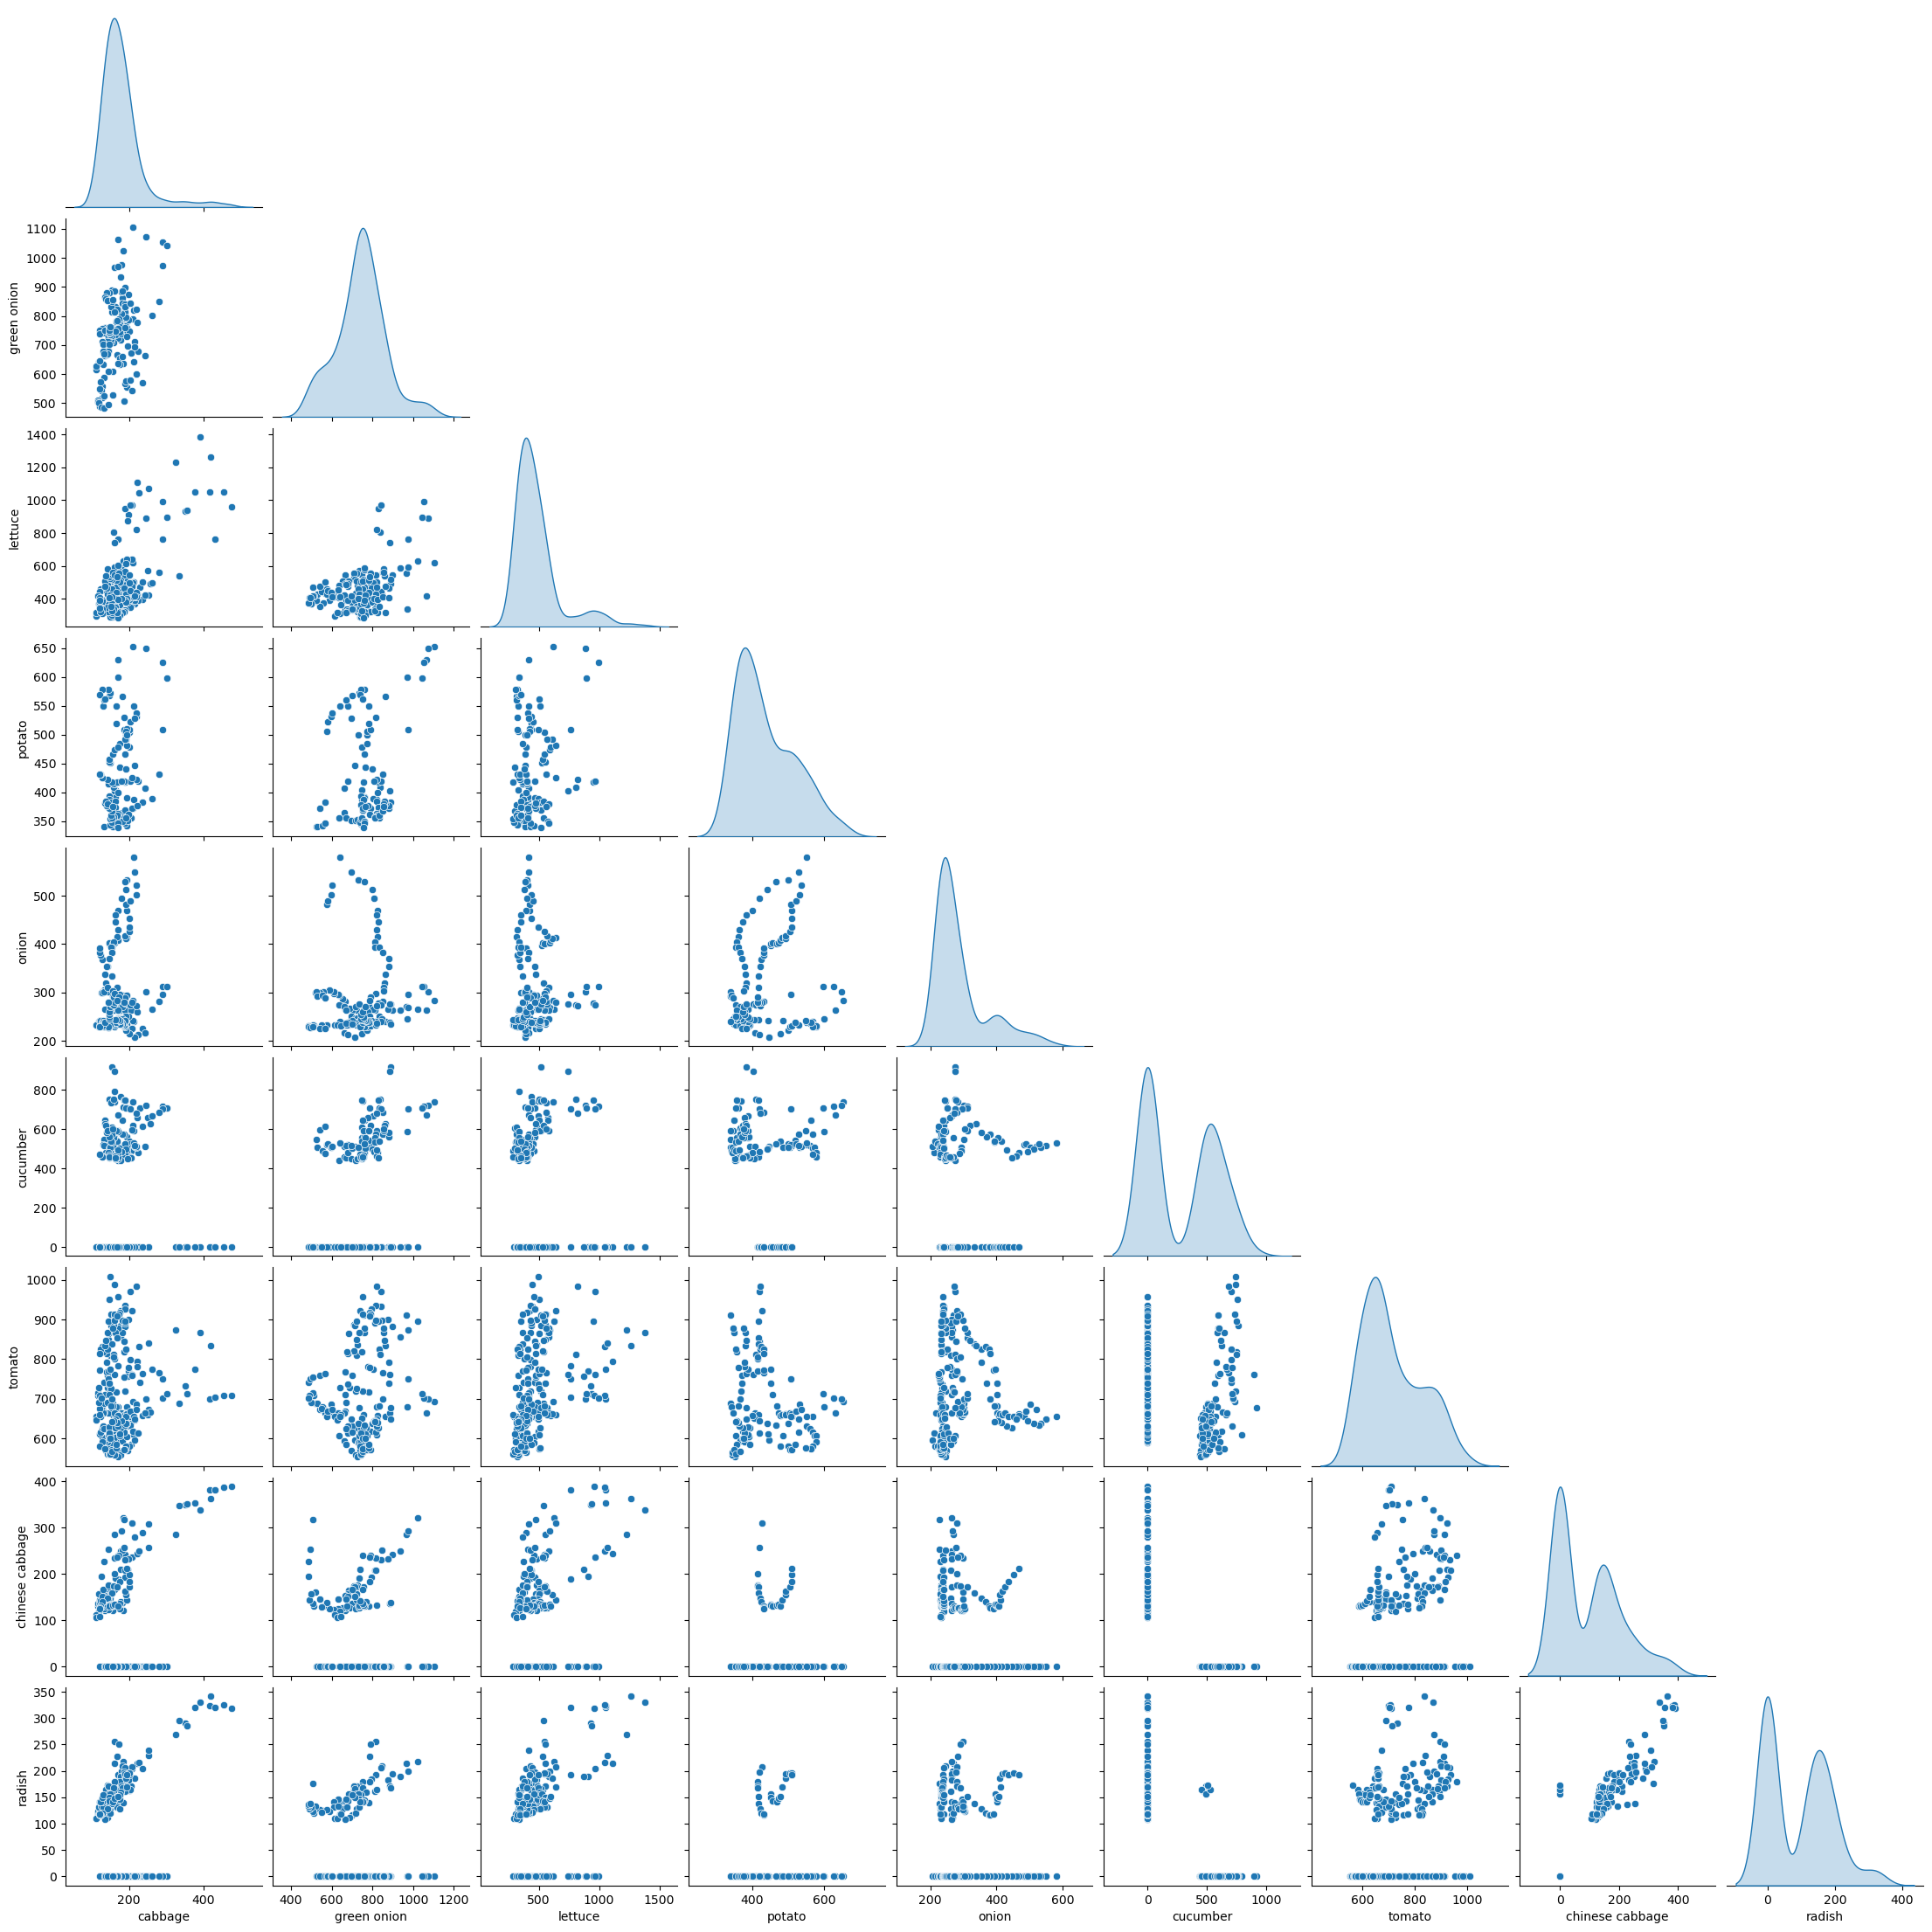

In [30]:
plt.figure(figsize=(10,10))

sns.pairplot(data=df, corner=True, diag_kind='kde')

plt.show()

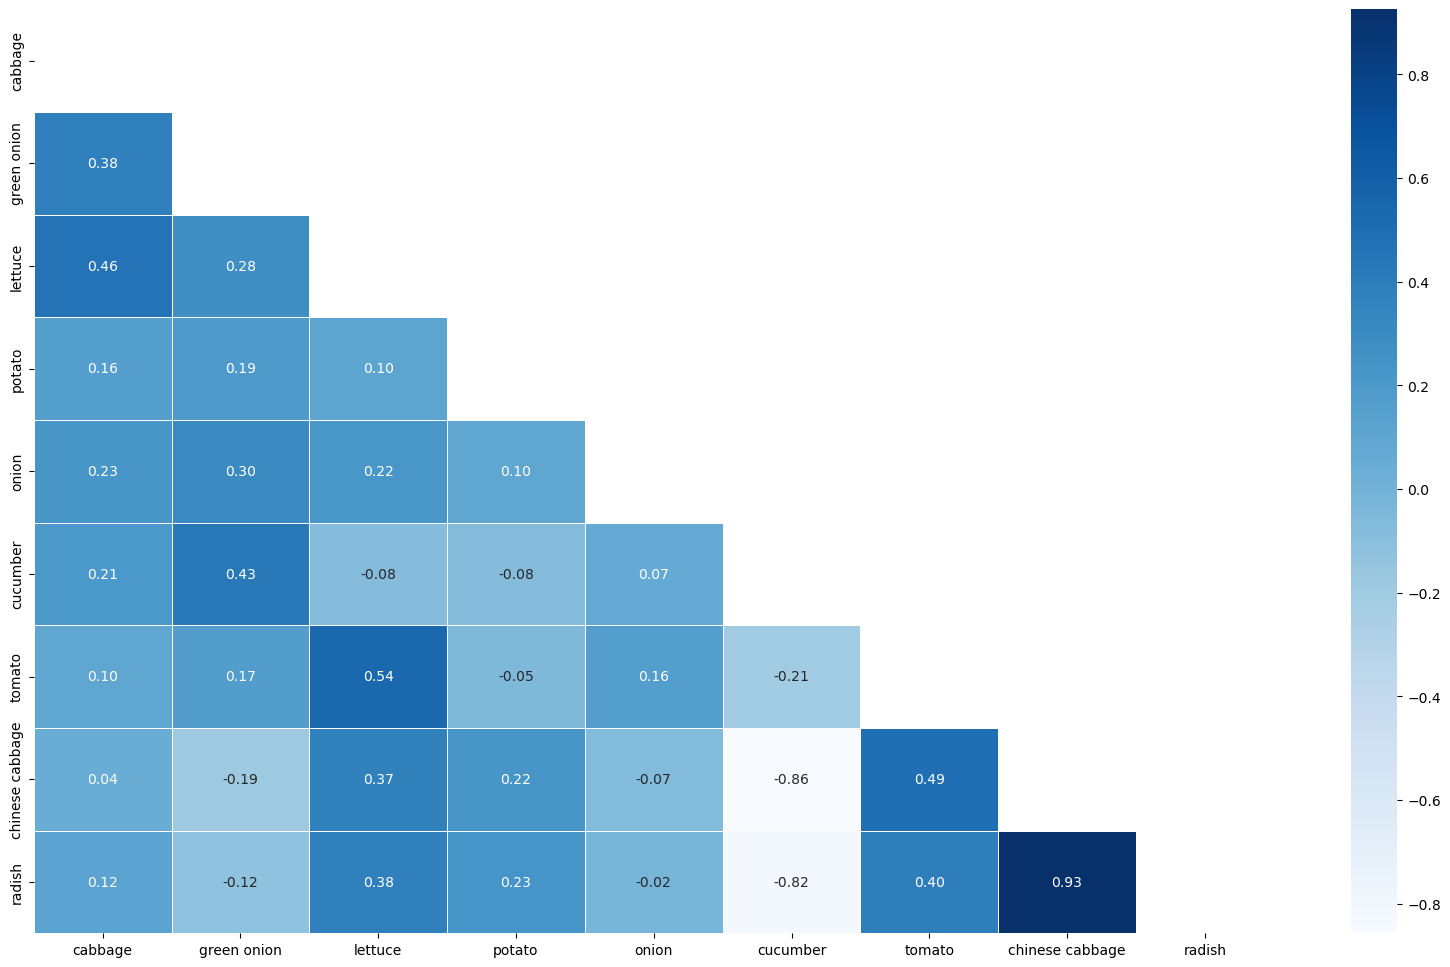

In [31]:
# find Spearman correlation of the independent variables
spearman_corr = df.corr(method='spearman')

# build mask to have only lower triangle of the correlation matrix
mask = np.triu(spearman_corr)

plt.figure(figsize=(20,12))
sns.heatmap(spearman_corr,  mask=mask, annot=True, cmap="Blues",
            fmt='.2f', linewidth=.5)

plt.show()

**Major Observations:**
1. `chinese cabbage` and `cucumber` have very high positive and very high negative correlation with `radish` respectively.
2. `chinese cabbage` and `cucumber` have very high negative correlation.
3. Other than the above, there is no significant correlation in the prices between the other vegetables.

#### v. Anomaly analysis using Z-Score

By analysing the Z-score, anomalies in time-series data can be detected.

However, since time-series is a form of sequential data, when determining the Z-scores, caution must be exercised.
- values across comparable time of the year must be compared in case of seasonal data.

From the above plots:
1. Vegetables without Seasonal price trend:
   - Cabbage
   - Green Onion
   - Lettuce
   - Potatoes
   - Onion
 - For these vegetables, a rolling lookback window will be used to calculate the mean and standard deviation
2. Vegetables with Seasonal price trend:
   - Cucumber
   - Tomato
   - Chinese Cabbage
   - Radish
 - For these vegetables, prices for similar weeks across the years will be compared

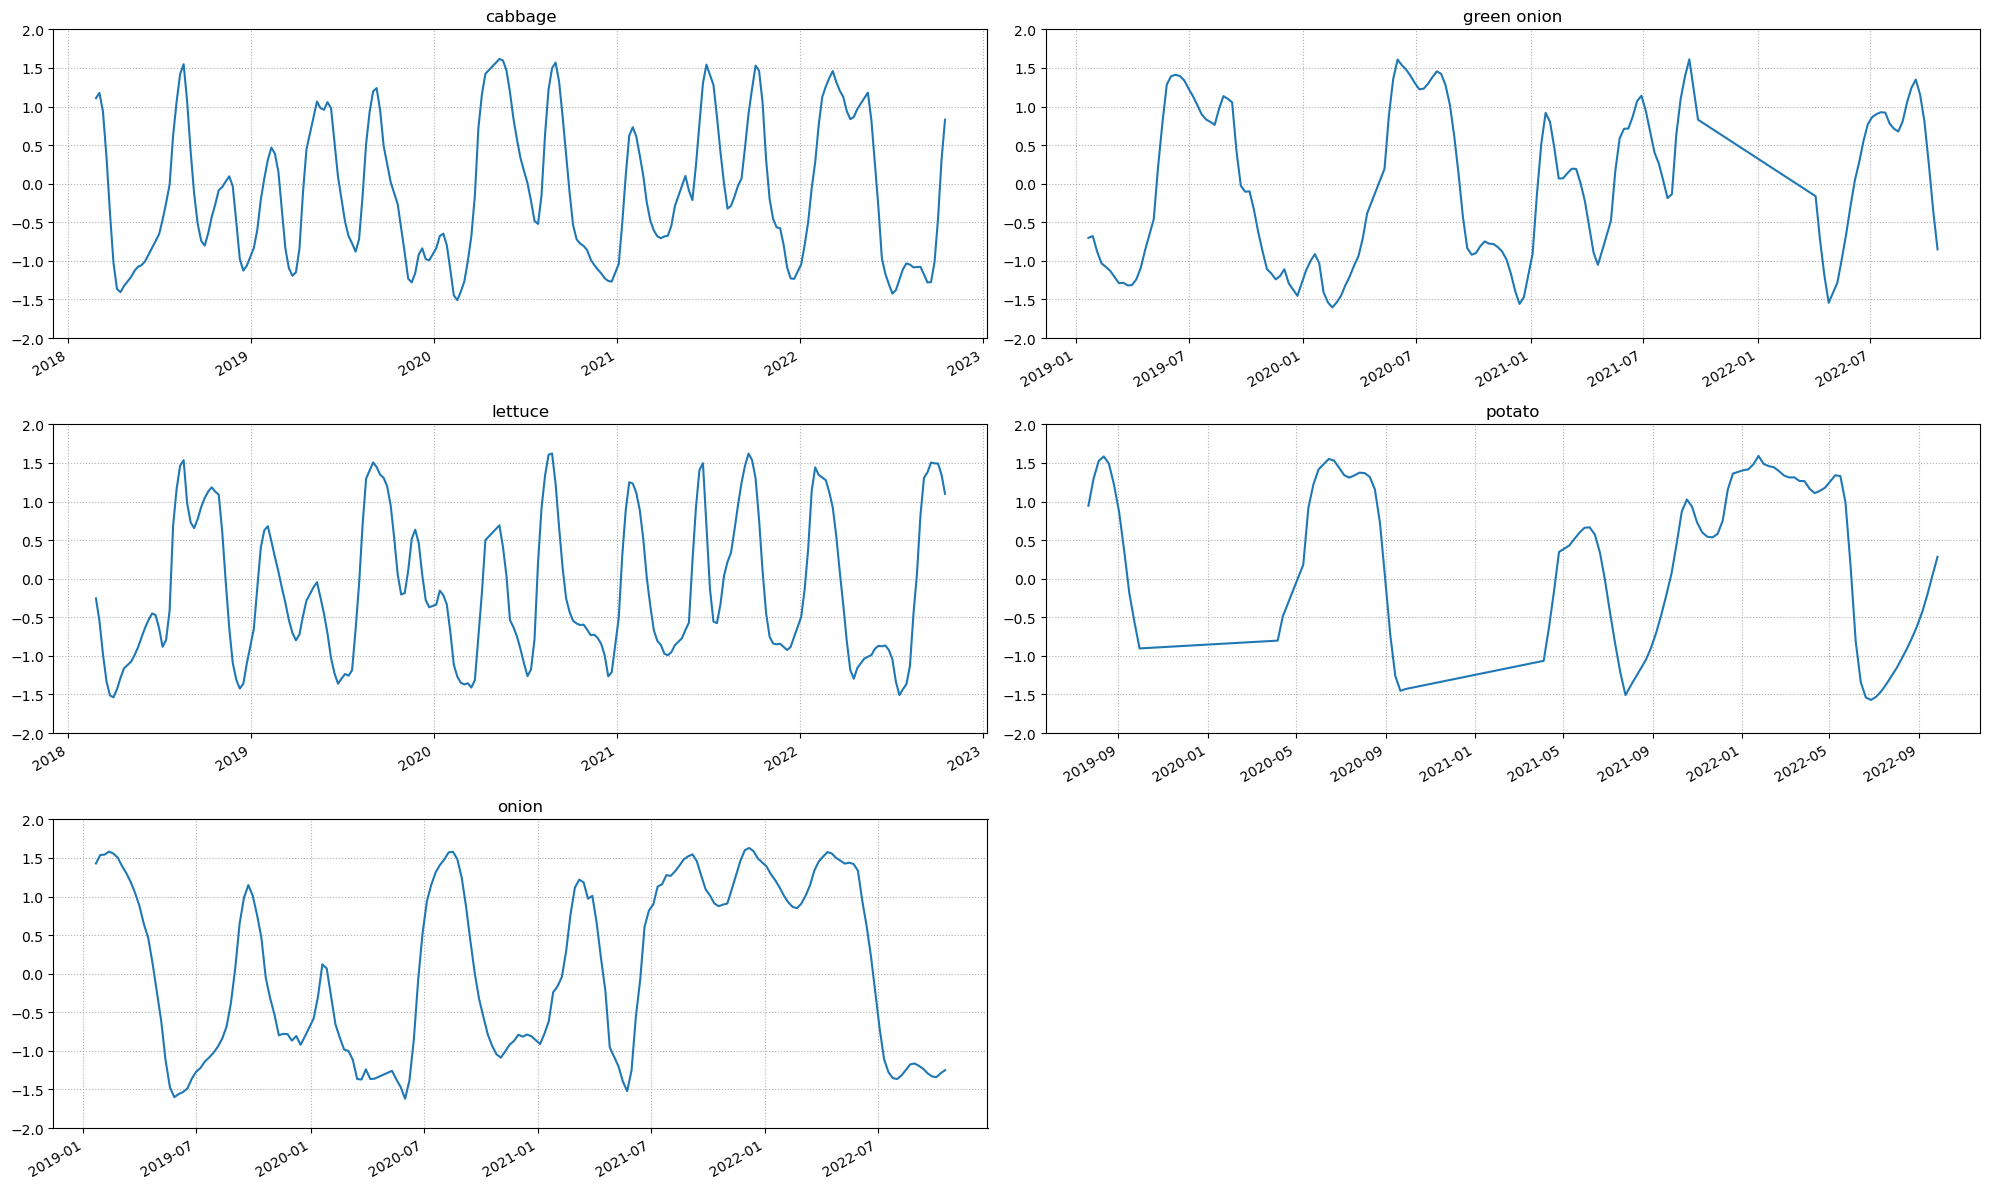

In [32]:
# list of non-seasonally priced vegetables
non_seasonal = ['cabbage', 'green onion', 'lettuce', 'potato', 'onion']

# params for rolling window based Z-scores
lookback = 16
smoothing = 4

# define figure
plt.figure(figsize=(20,12))
idx = 1

for veg in non_seasonal:
    plt.subplot(3, 2, idx)

    tmp_df = df.dropna(subset=[veg])

    result = pd.DataFrame()
    
    # calculate rolling mean and standard deviation
    result['mean'] = tmp_df[veg].rolling(window=lookback).mean(min_period=lookback)
    result['std_dev'] = tmp_df[veg].rolling(window=lookback).std(min_period=lookback, ddof=0)

    # calculate z-score based on the above mean and standard deviation
    result['z_score'] = (tmp_df[veg].rolling(window=smoothing).mean() - result['mean']) / result['std_dev']

    # plot the results
    result['z_score'].plot()
    plt.title(veg)
    plt.ylim(-2, 2)
    plt.grid(visible=True, linestyle=':')
    plt.tight_layout()

    idx += 1

plt.show()
del tmp_df, result

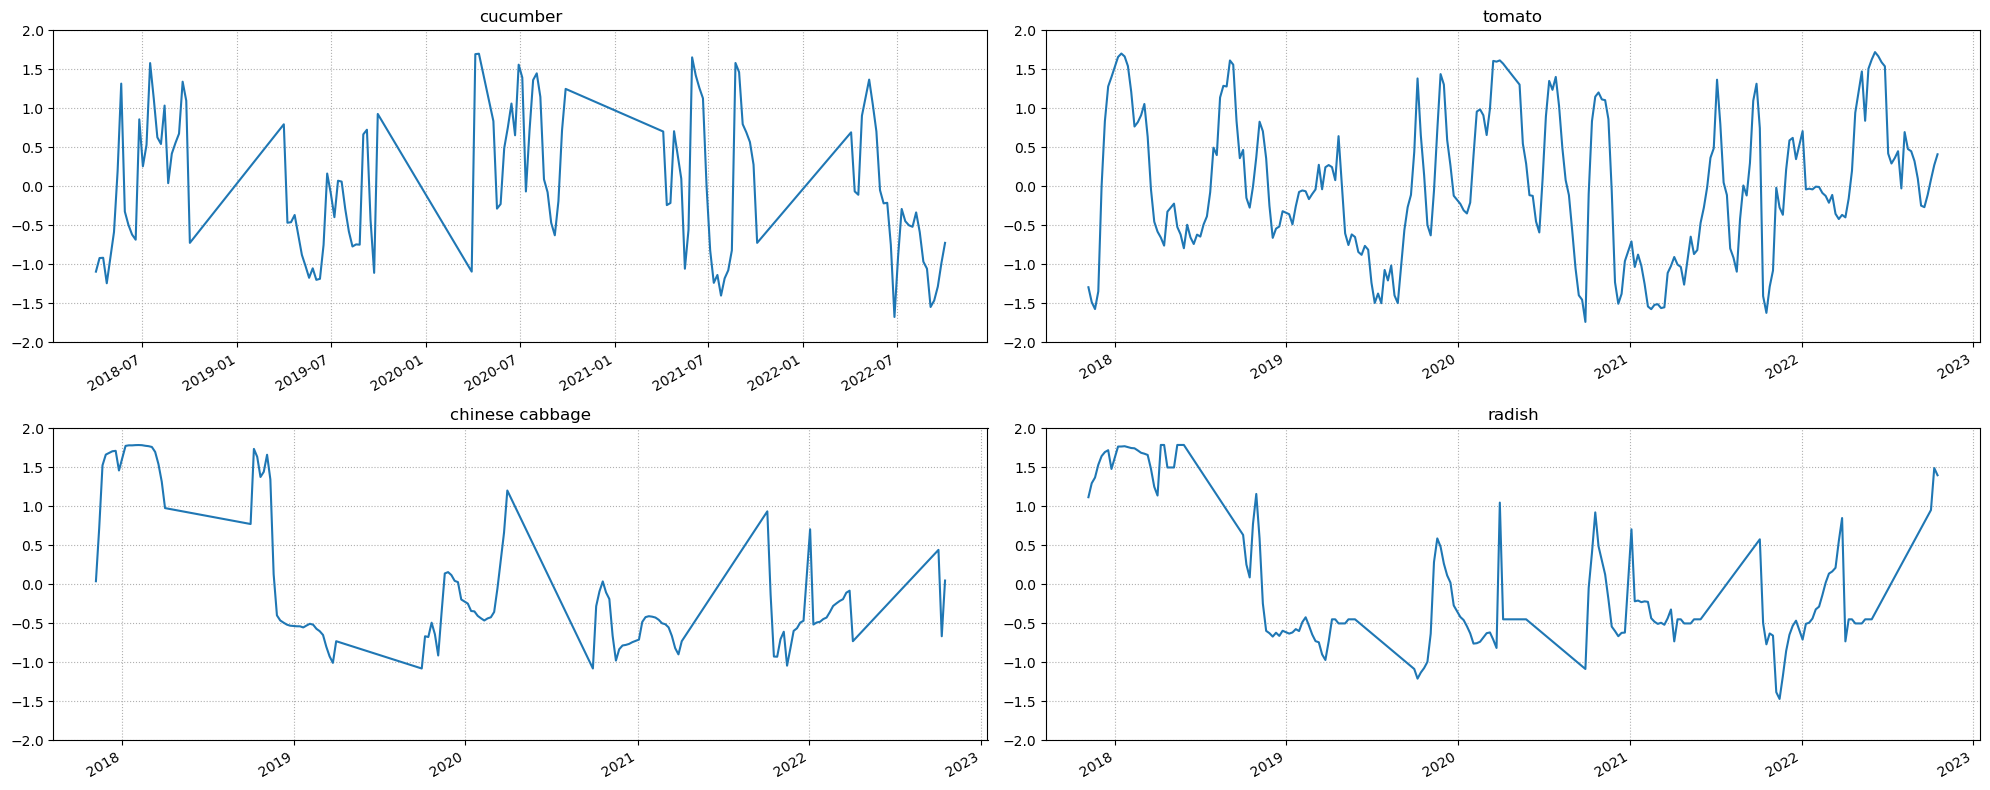

In [33]:
# list of seasonally priced vegetables
seasonal = ['cucumber', 'tomato', 'chinese cabbage', 'radish']

tmp_df = df[df.columns[df.columns.isin(seasonal)]].copy(deep=True)

# calculate mean and standard deviation across similar weeks of the year
mean_ts = tmp_df.groupby(by=[tmp_df.index.isocalendar().week]).aggregate(np.nanmean)
std_dev_ts = tmp_df.groupby(by=[tmp_df.index.isocalendar().week]).aggregate(np.nanstd)

# calculate z-score considering mean and standard deviation from similar weeks across the years
result = tmp_df.copy()
for y in np.unique(tmp_df.index.year):
    for d in np.unique(tmp_df.index.isocalendar().week):
        result[(tmp_df.index.year==y) & (tmp_df.index.isocalendar().week==d)] = (tmp_df[(tmp_df.index.year==y) & (tmp_df.index.isocalendar().week==d)]- mean_ts.loc[d])/std_dev_ts.loc[d]


# define figure
plt.figure(figsize=(20,8))
idx = 1

for veg in result.columns:
    plt.subplot(2, 2, idx)

    tmp_df = result.dropna(subset=[veg])

    # plot the results
    tmp_df[veg].plot()
    plt.title(veg)
    plt.ylim(-2, 2)
    plt.grid(visible=True, linestyle=':')
    plt.tight_layout()

    idx += 1

plt.show()
del tmp_df, result

From the above plots for Z-score, it can be said that there are no anomalies in our time-series data
- For all the vegetables, all the data points lies within 2 standard deviations from the mean.

#### vi. Interpolate using different methods

**Linear Interpolation**

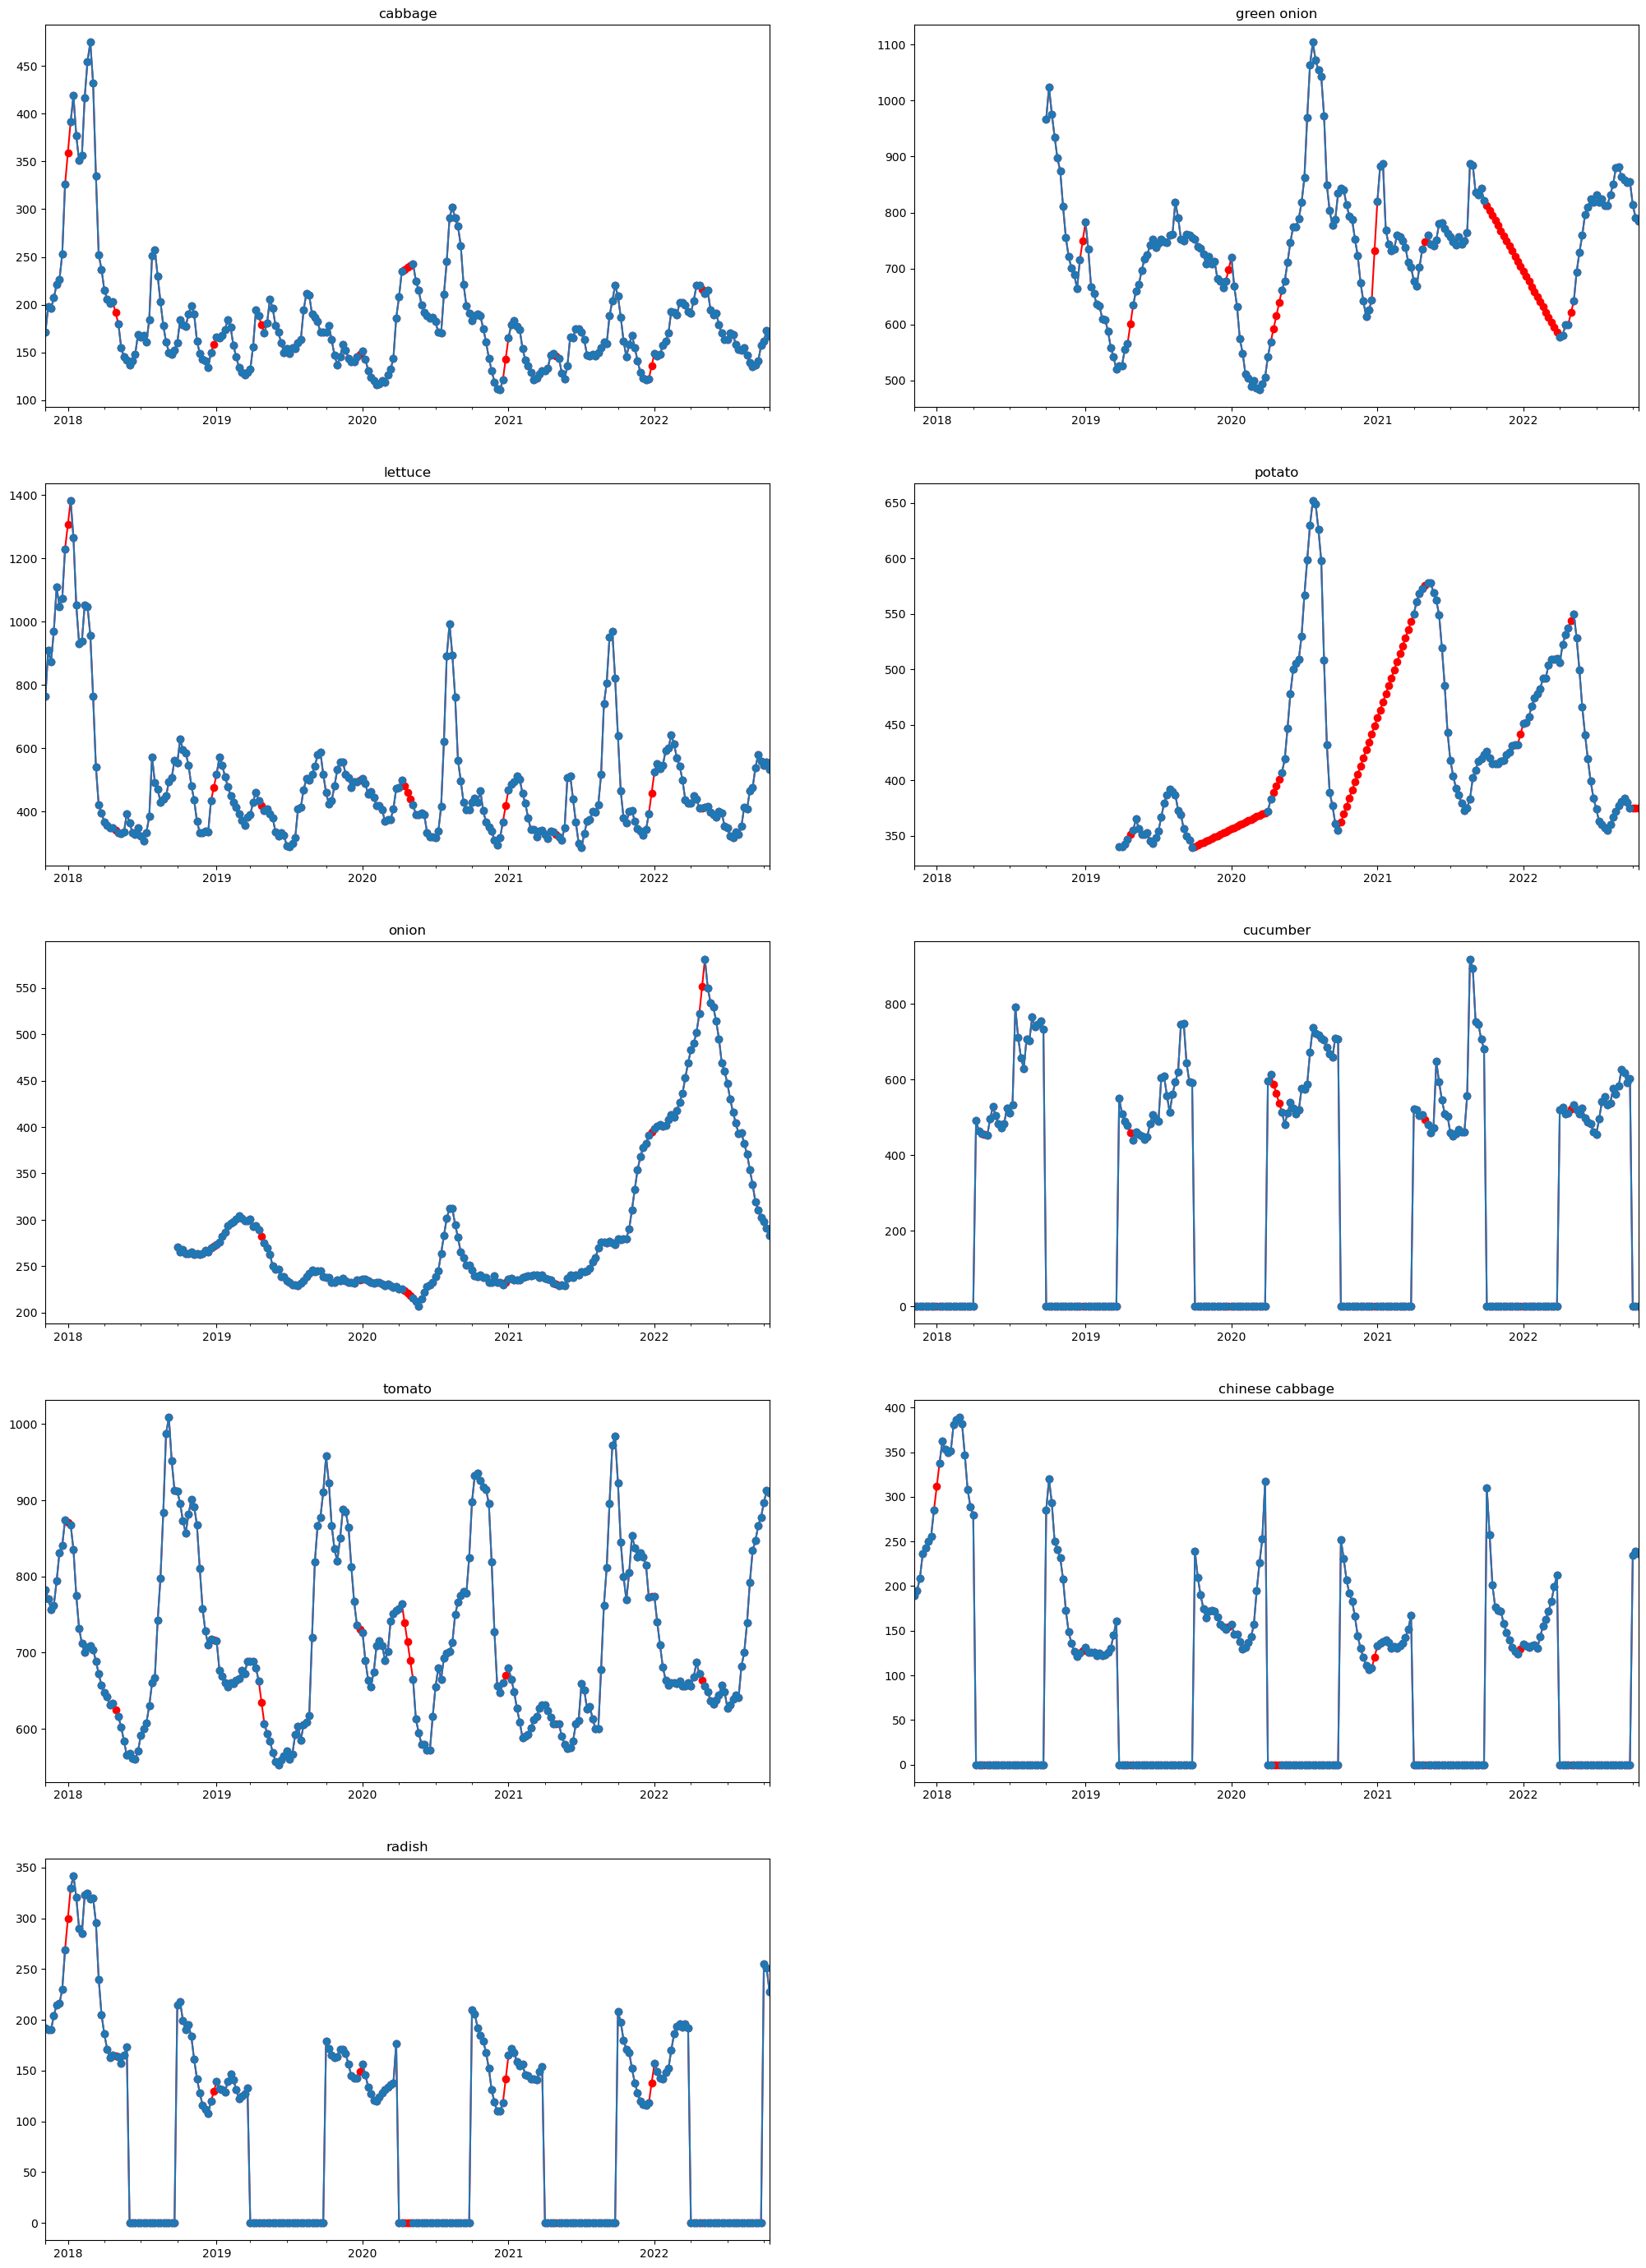

In [34]:
# create a copy of the dataset
tmp_df = df.copy()

# apply interpolation
tmp_df = df.interpolate()

# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    tmp_df[col_name].plot(color='red', marker='o')
    df[col_name].plot(marker='o')
    plt.title(col_name)

    col_mean_orig = df[col_name].mean()
    col_mean_imp = tmp_df[col_name].mean()
    sns.lineplot(x=df.index, y=col_mean_orig, legend=False)
    sns.lineplot(x=df.index, y=col_mean_imp, legend=False)

    idx += 1

plt.show()

**cubicspline Interpolation**

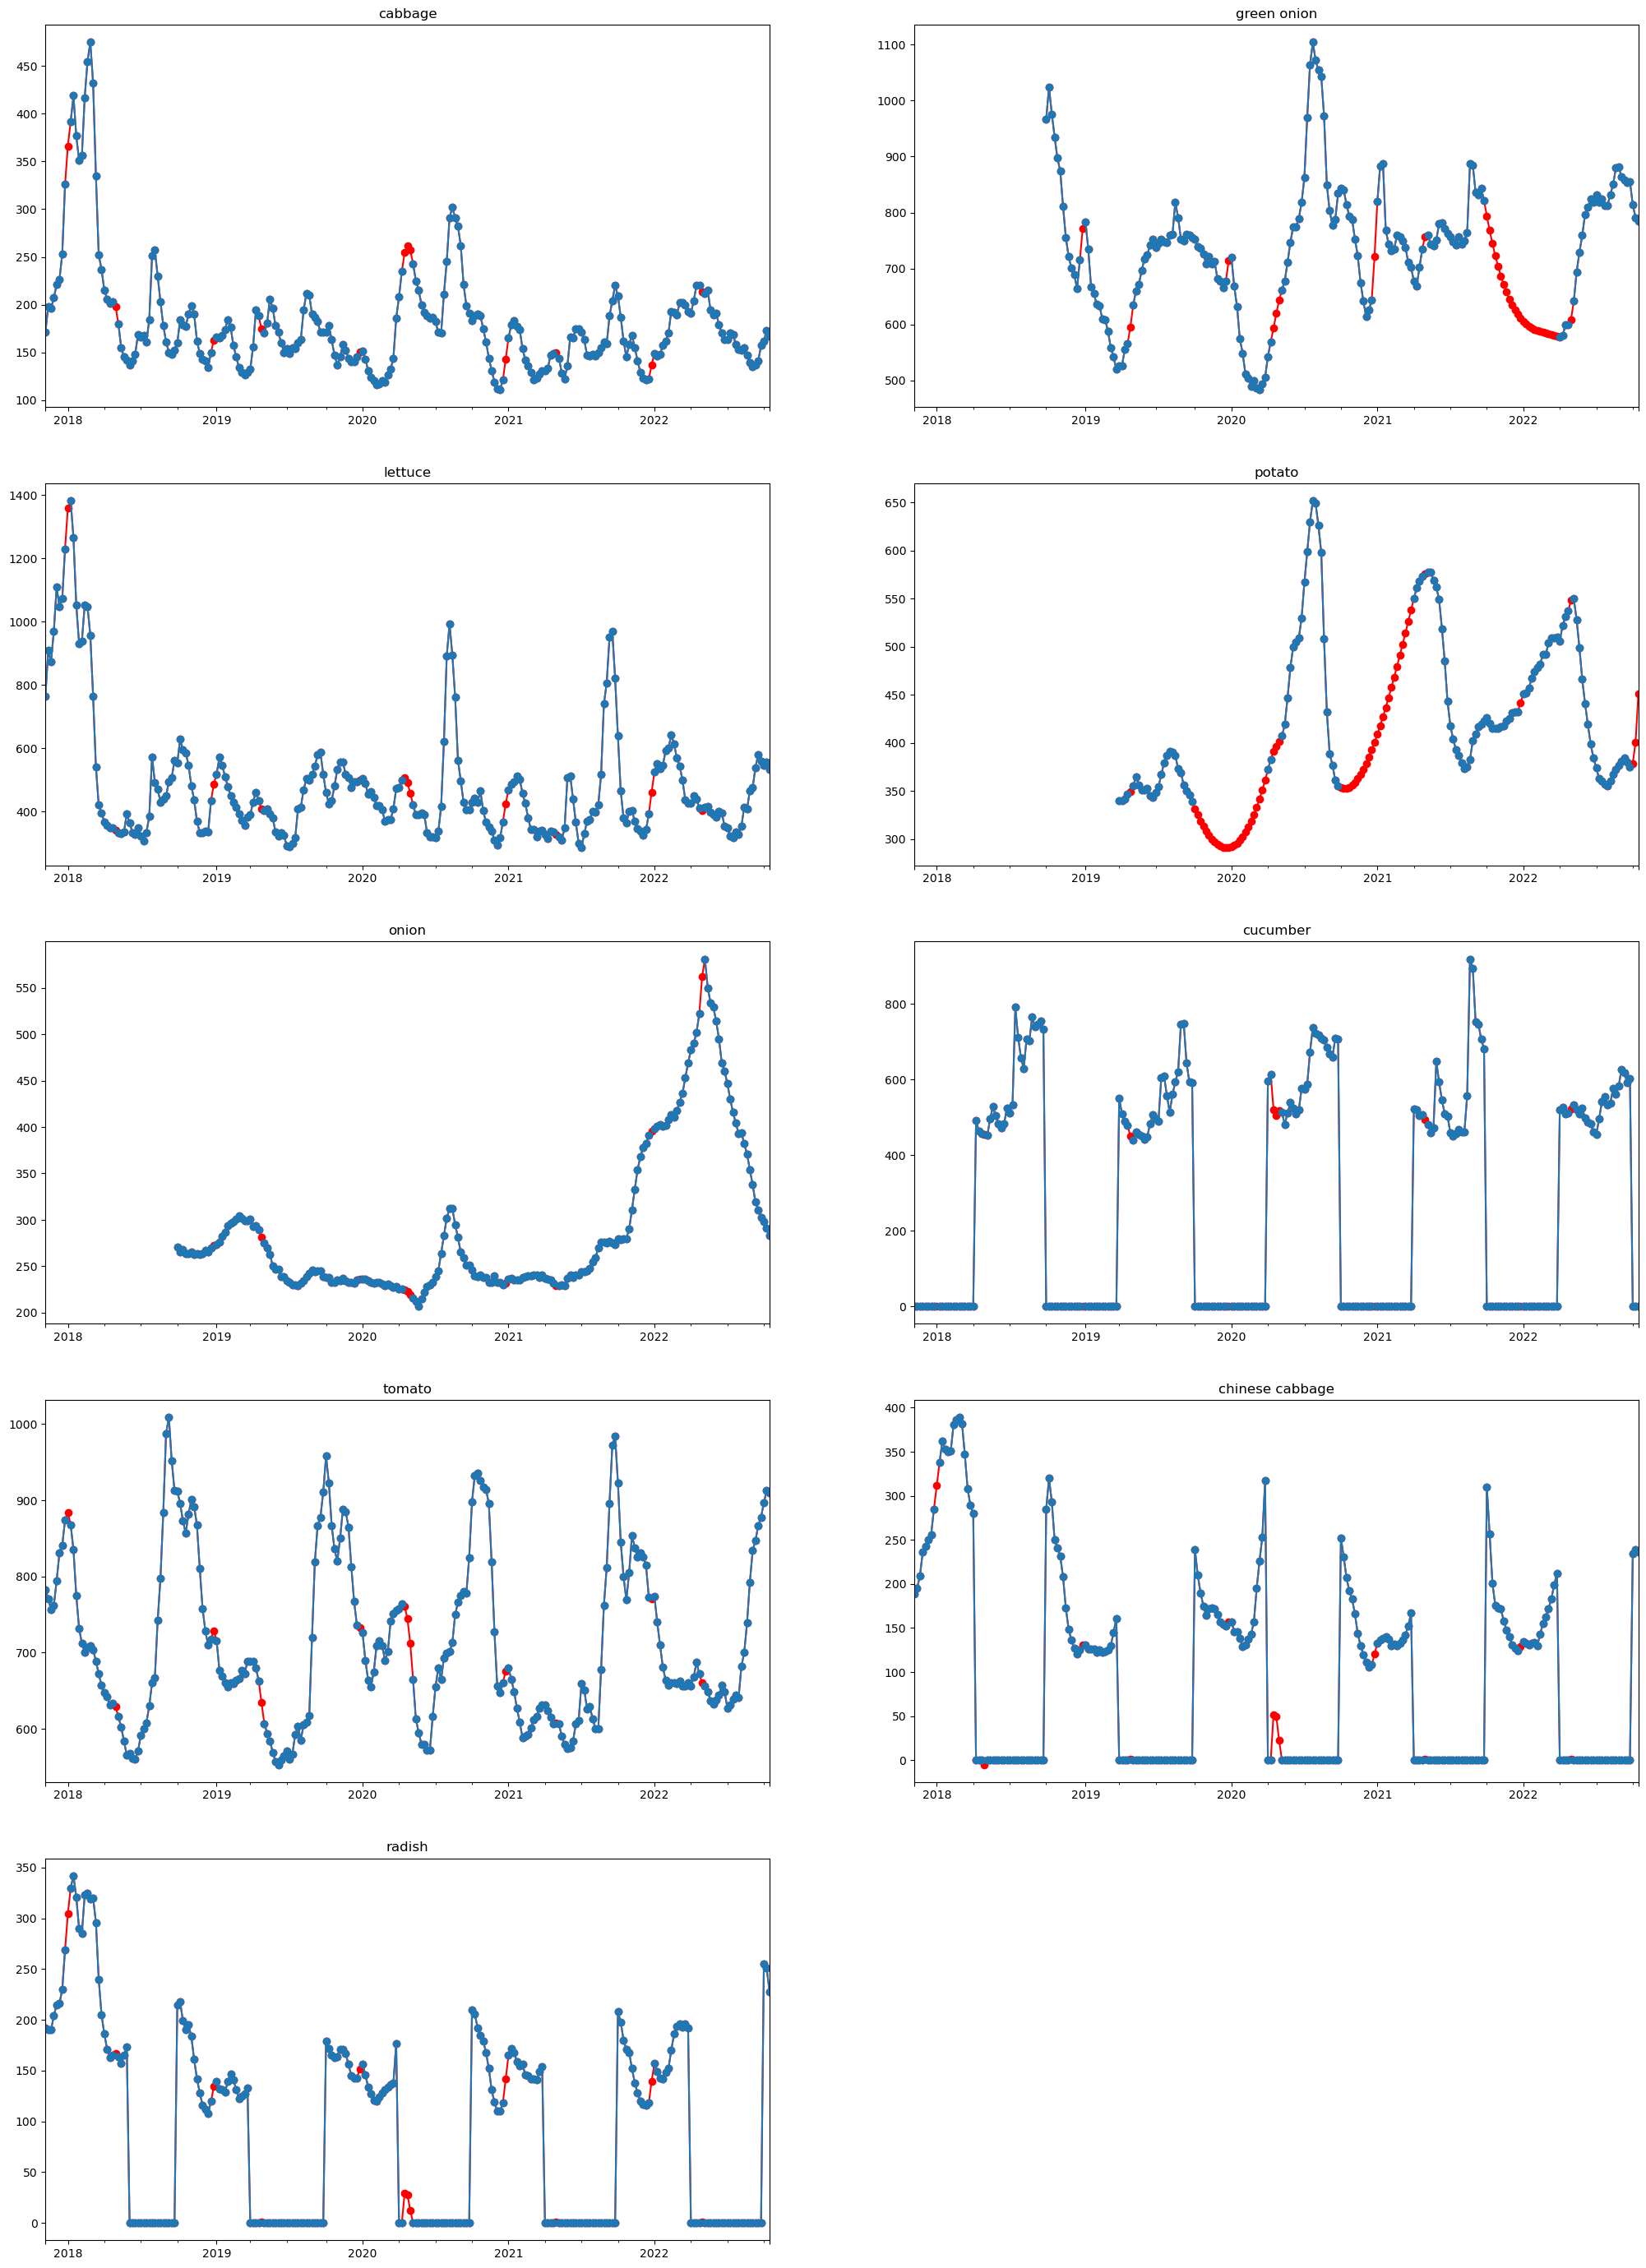

In [35]:
# create a copy of the dataset
tmp_df = df.copy()

# apply interpolation
tmp_df = df.interpolate(method='cubicspline', order=3)

# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    tmp_df[col_name].plot(color='red', marker='o')
    df[col_name].plot(marker='o')
    plt.title(col_name)

    col_mean_orig = df[col_name].mean()
    col_mean_imp = tmp_df[col_name].mean()
    sns.lineplot(x=df.index, y=col_mean_orig, legend=False)
    sns.lineplot(x=df.index, y=col_mean_imp, legend=False)
    
    idx += 1

plt.show()

**Spline Interpolation**

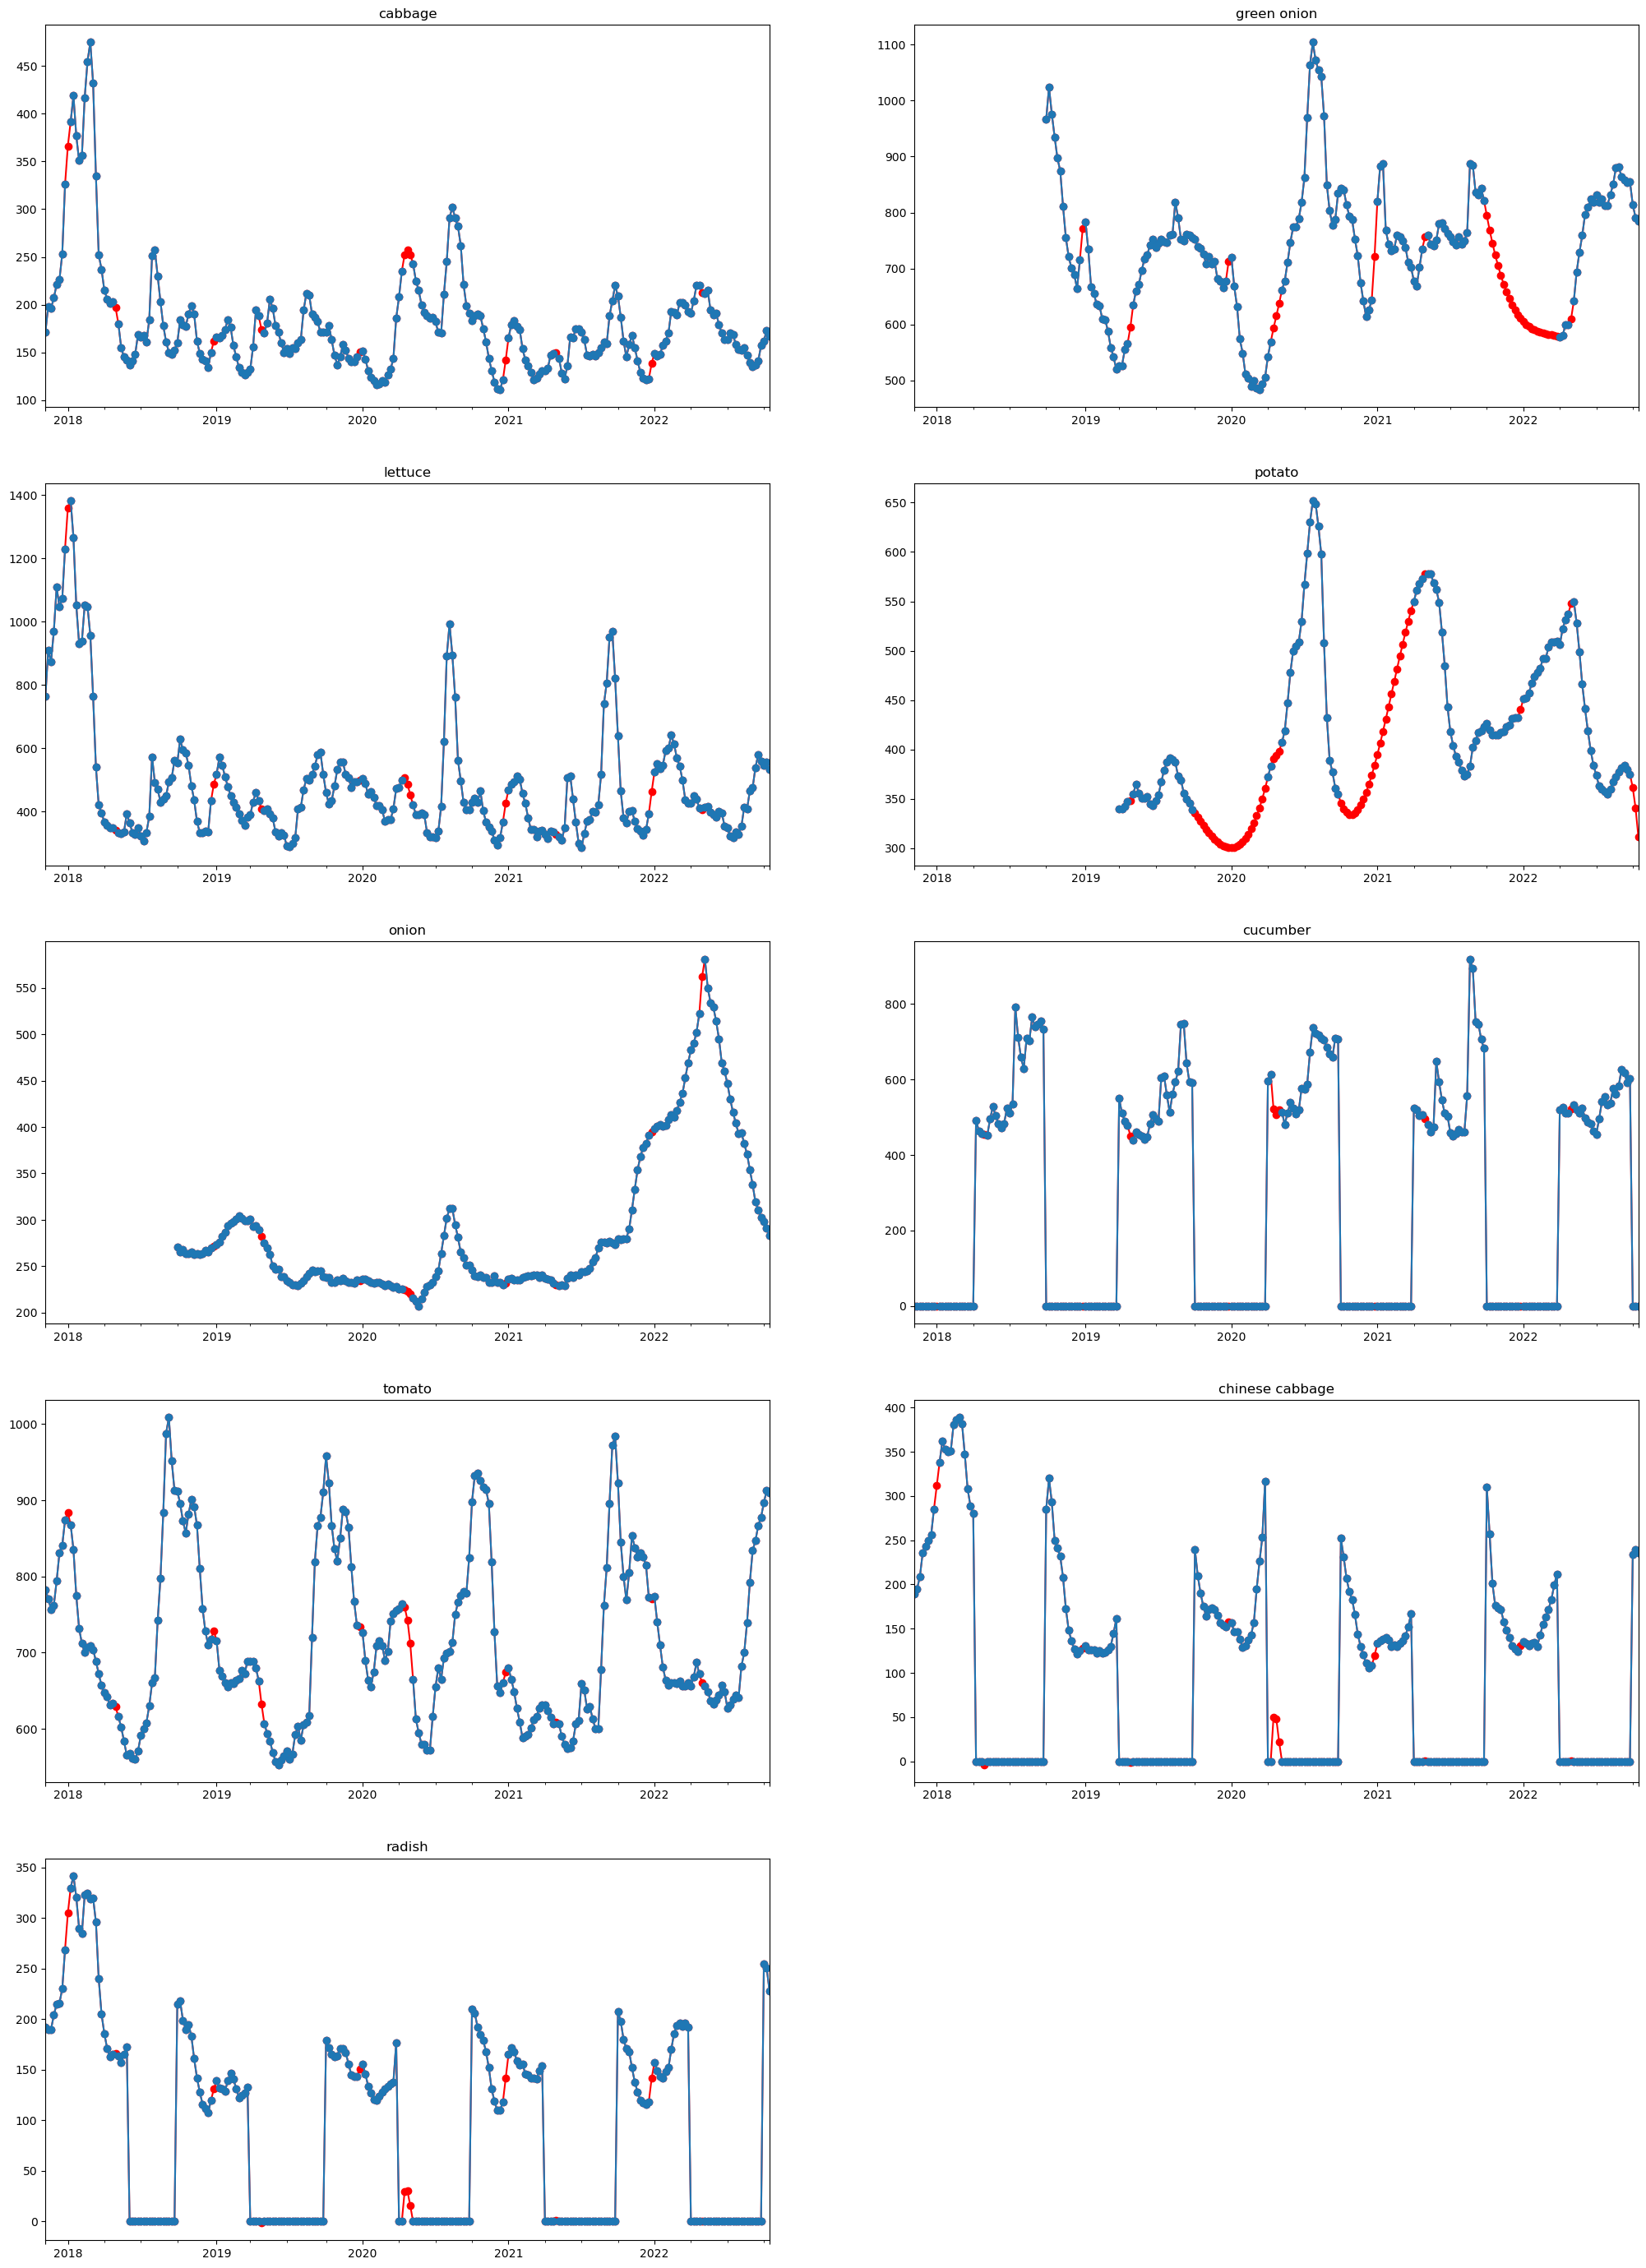

In [36]:
# create a copy of the dataset
tmp_df = df.copy()

# apply interpolation
tmp_df = df.interpolate(method='spline', order=3)

# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    tmp_df[col_name].plot(color='red', marker='o')
    df[col_name].plot(marker='o')
    plt.title(col_name)

    col_mean_orig = df[col_name].mean()
    col_mean_imp = tmp_df[col_name].mean()
    sns.lineplot(x=df.index, y=col_mean_orig, legend=False)
    sns.lineplot(x=df.index, y=col_mean_imp, legend=False)
    
    idx += 1

plt.show()

**akima Interpolation**

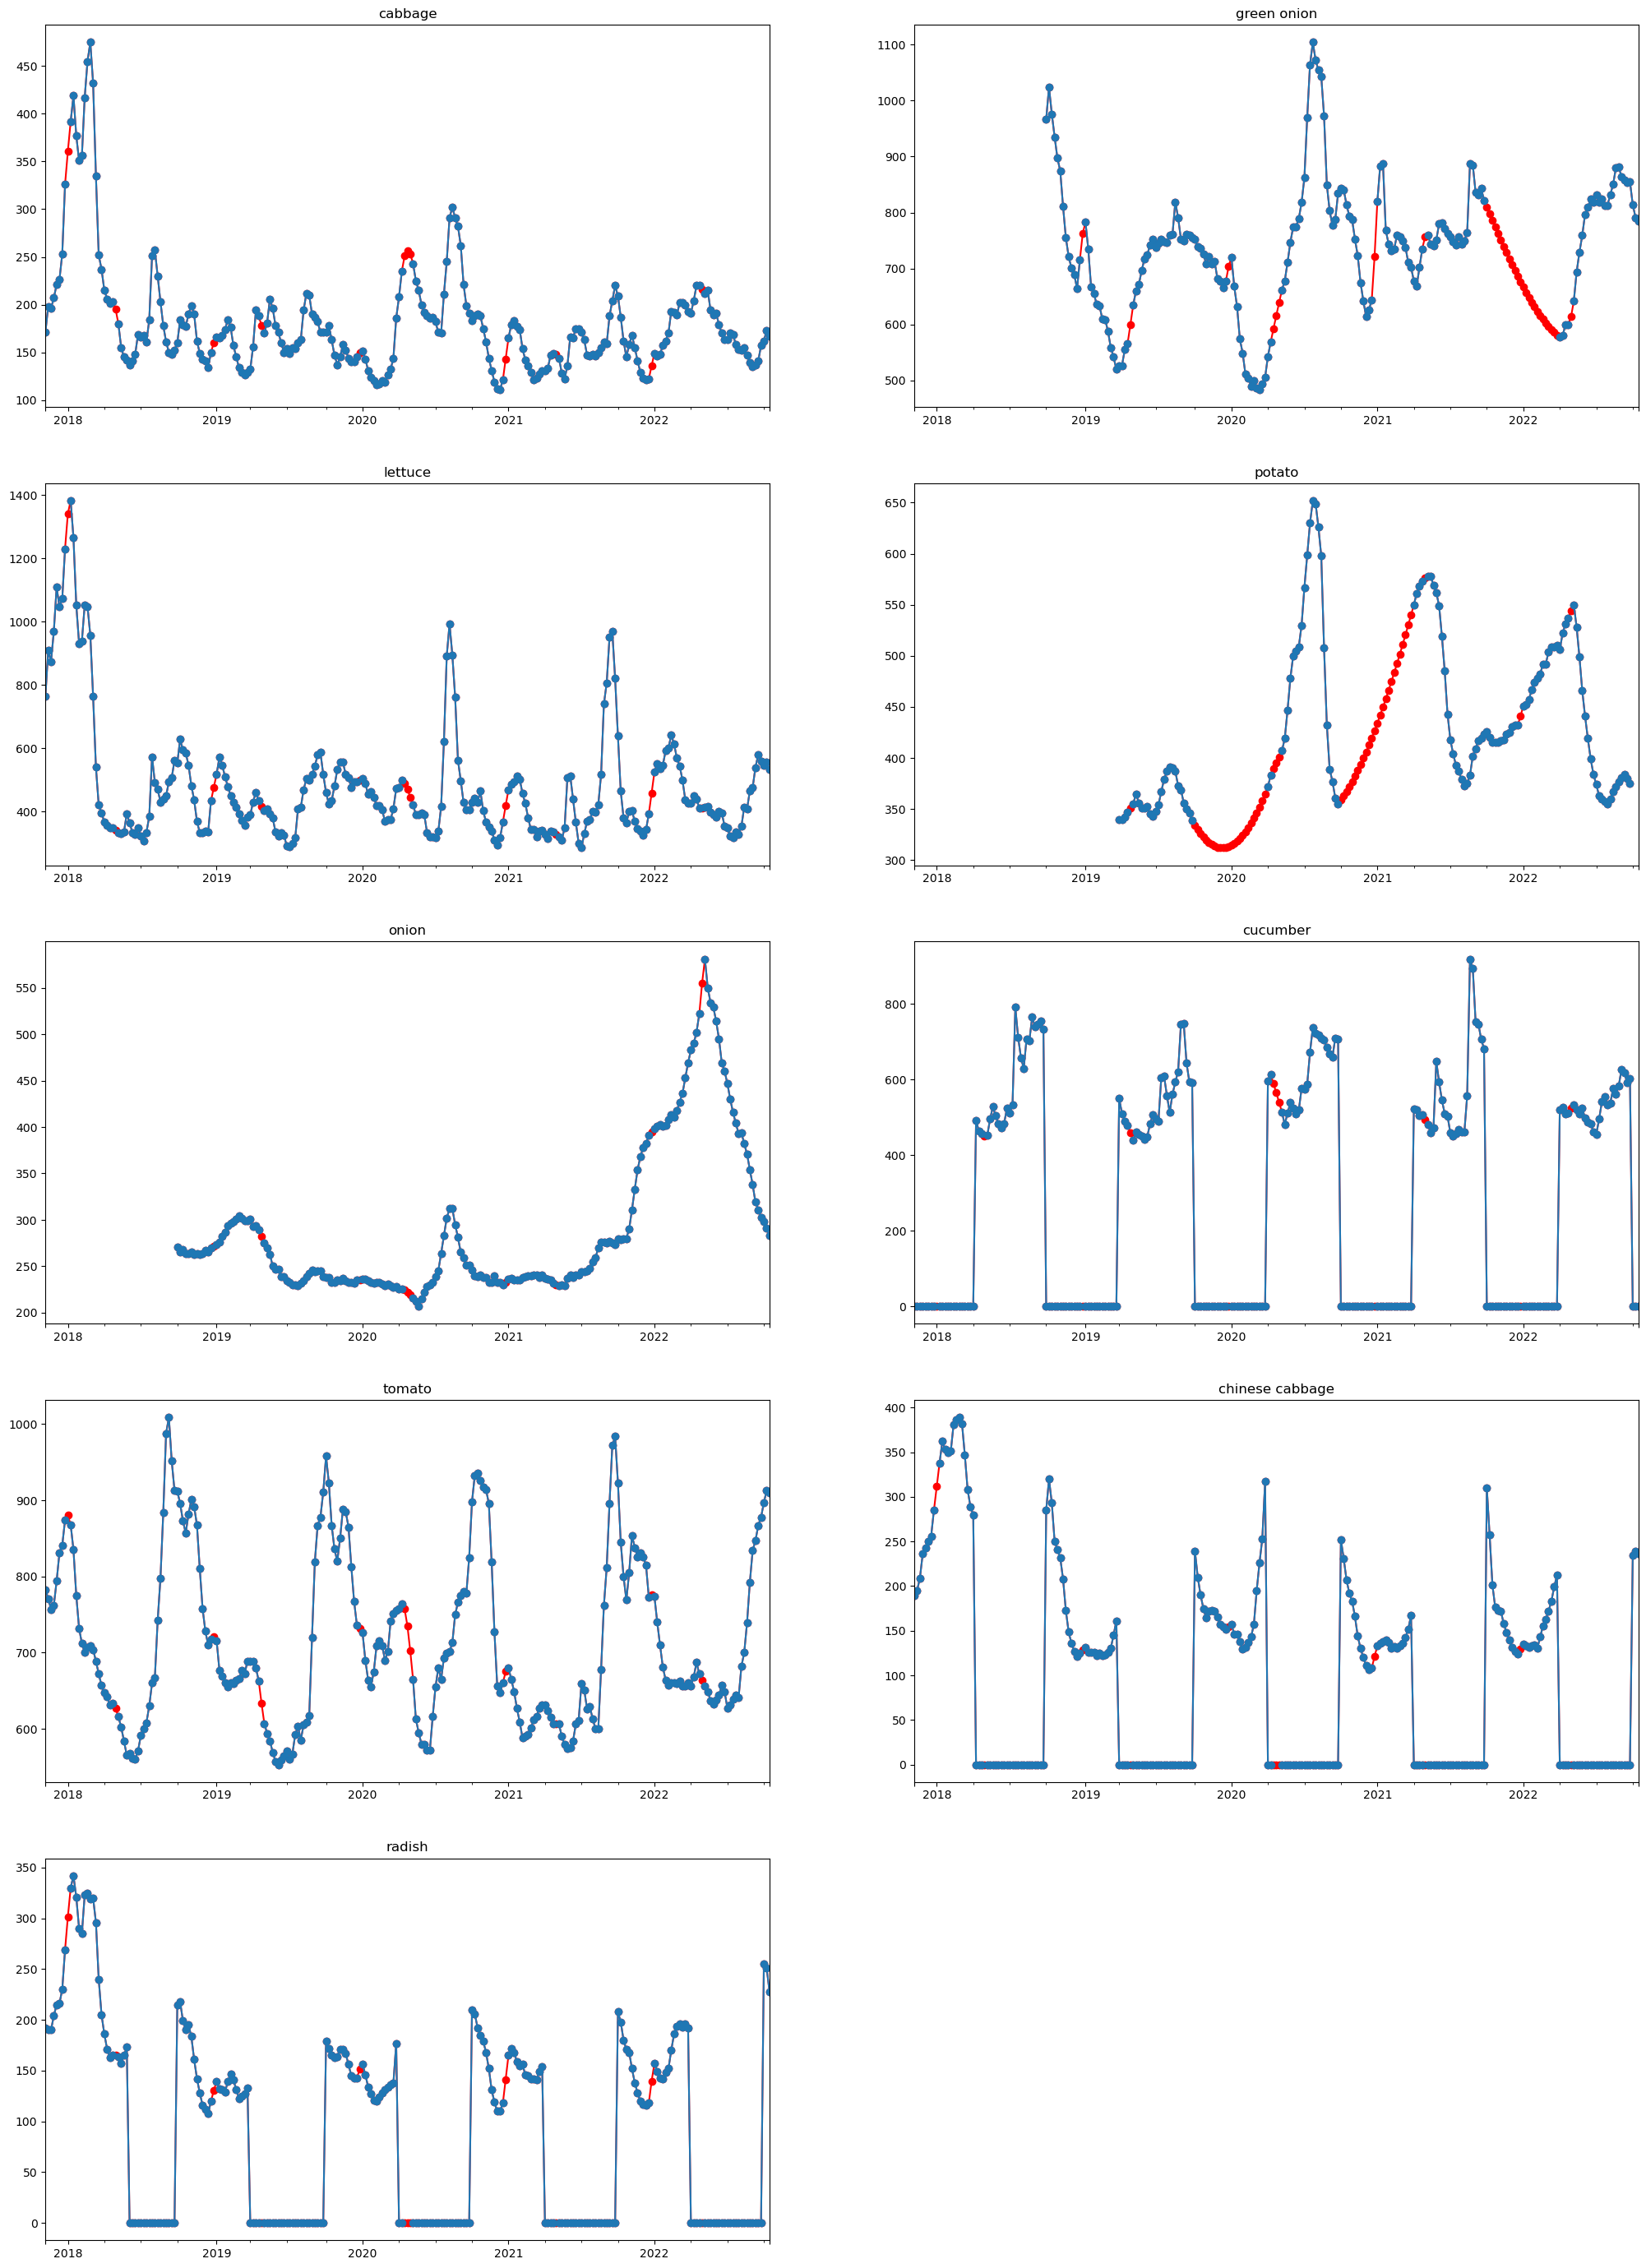

In [37]:
# create a copy of the dataset
tmp_df = df.copy()

# apply interpolation
tmp_df = df.interpolate(method='akima')

# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    tmp_df[col_name].plot(color='red', marker='o')
    df[col_name].plot(marker='o')
    plt.title(col_name)

    col_mean_orig = df[col_name].mean()
    col_mean_imp = tmp_df[col_name].mean()
    sns.lineplot(x=df.index, y=col_mean_orig, legend=False)
    sns.lineplot(x=df.index, y=col_mean_imp, legend=False)
    
    idx += 1

plt.show()

**pchip Interpolation**

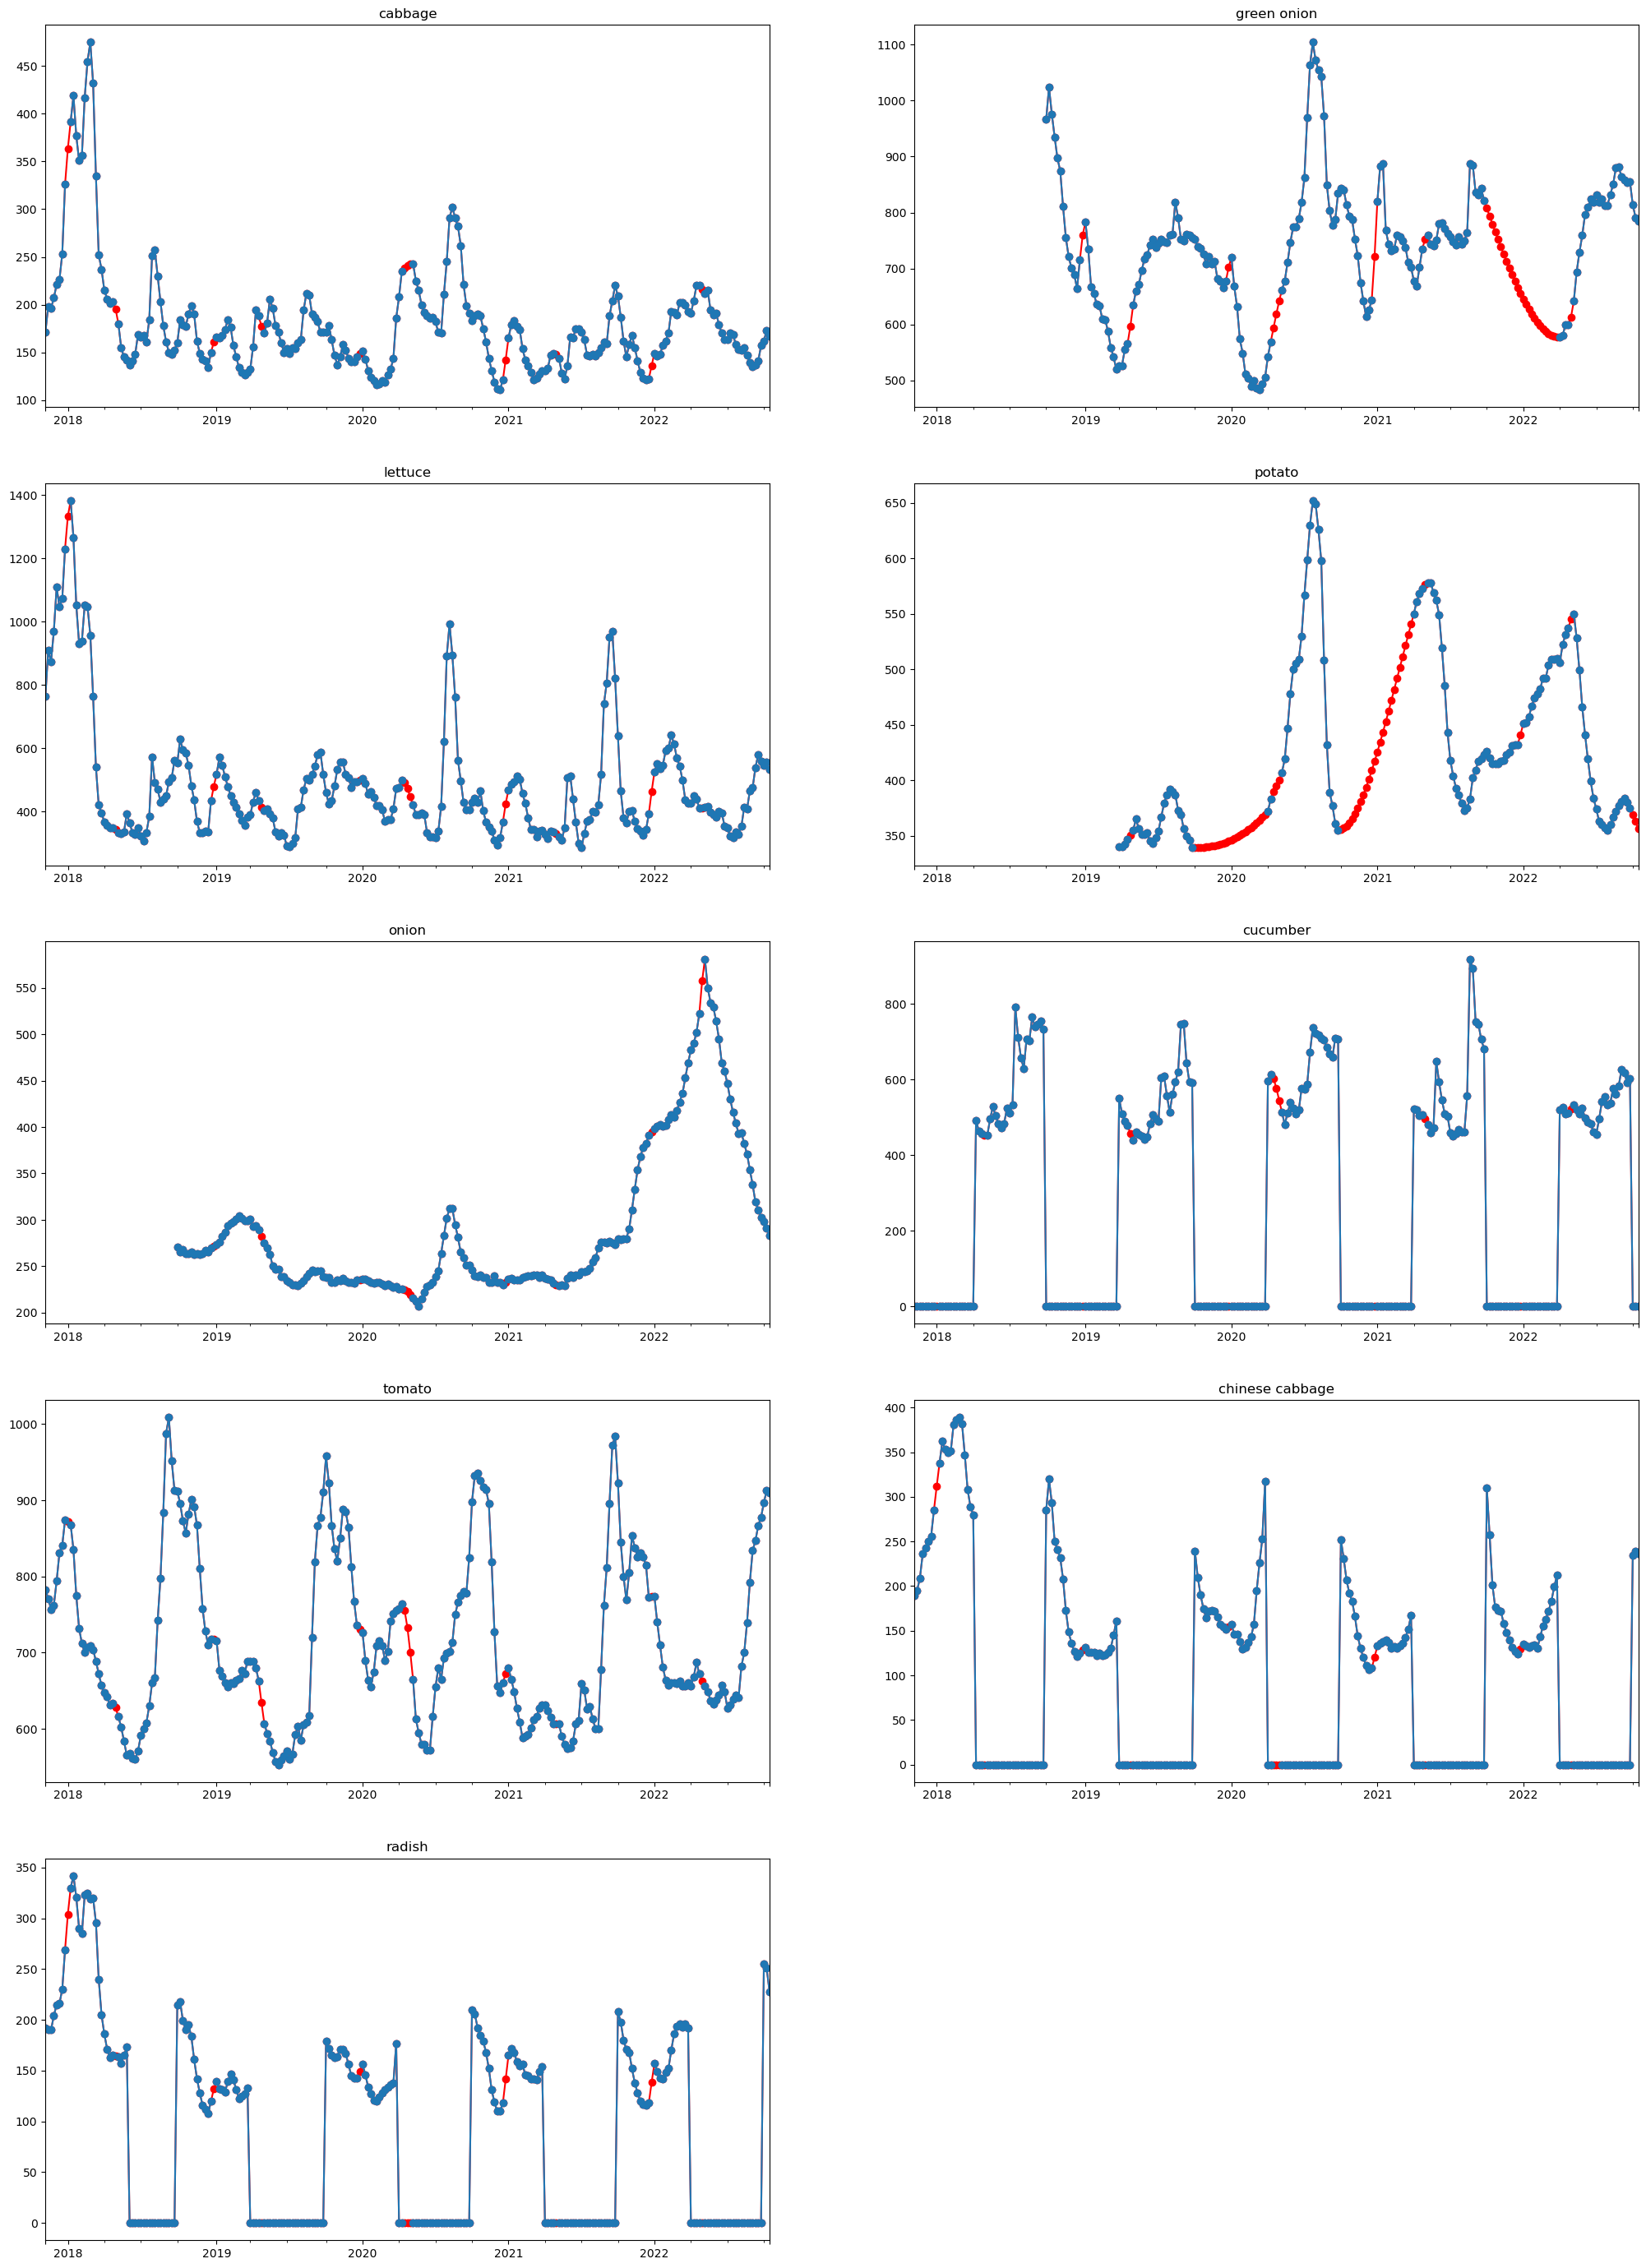

In [38]:
# create a copy of the dataset
tmp_df = df.copy()

# apply interpolation
tmp_df = df.interpolate(method='pchip')

# define figure
plt.figure(figsize=(25,35))
idx = 1

# plot for all the columns
for col_name in df.columns:
    plt.subplot(5, 2, idx)
    tmp_df[col_name].plot(color='red', marker='o')
    df[col_name].plot(marker='o')
    plt.title(col_name)

    col_mean_orig = df[col_name].mean()
    col_mean_imp = tmp_df[col_name].mean()
    sns.lineplot(x=df.index, y=col_mean_orig, legend=False)
    sns.lineplot(x=df.index, y=col_mean_imp, legend=False)
    
    idx += 1

plt.show()

From the above plots:
- `spline`, `cubicspline`, `akima` and `pchip` interpolation methods provides the best results
- with smooth trends

So, we will use either one of the above methods for the interpolation.

In [39]:
# interpolate the missing values
df_akima = df.interpolate(method='akima')

df_akima.head()

cabbage  green onion  lettuce  potato  onion  cucumber  tomato  \
2017-11-06    171.0          NaN    763.0     NaN    NaN       0.0   783.0   
2017-11-13    198.0          NaN    909.0     NaN    NaN       0.0   771.0   
2017-11-20    196.0          NaN    873.0     NaN    NaN       0.0   757.0   
2017-11-27    207.0          NaN    969.0     NaN    NaN       0.0   762.0   
2017-12-04    221.0          NaN   1109.0     NaN    NaN       0.0   794.0   

            chinese cabbage  radish  
2017-11-06            189.0   192.0  
2017-11-13            195.0   190.0  
2017-11-20            209.0   190.0  
2017-11-27            236.0   204.0  
2017-12-04            243.0   215.0

However, some missing values are still present for some vegetables,
- specifically at the start of the time series
- so, these missing values are filled with mean of the respective columns to avoid any missing values before training the neural network models.
- but this will be done after splitting the data into training and testing set to avoid data leakage.

## Data Transformation

From the above sections, there are 9 vegetables, and
- the future price of these vegetables are to be predicted.
- Using RNN, LSTM & GRU, models will be built which will give a sequence of future predictions based on past time-series data
- To enable this, the dataset has to be transformed such that the independent features consist of the past time-series data, and
- the target feature consists of the intended future values for the corresponding past data.

![Alt text](DataTransformationpic.png)


Also, for now the model will be trained to only predict the price of one vegetable
- for eg: `cabbage`
- so, the target feature will have data of only `cabbage` and the independent features will have data for all the 9 vegetables.

### Split into Training and Testing dataset

Before proceeding further, the data is divided into training and testing datasets.
- the data until the year of 2021 is used for training and validation, and
- the data from the year of 2022 is used for testing the model

In [40]:
# build training and testing dataset
train_df = df_akima[:'2021-12-27'].copy()
test_df = df_akima['2022-01-03':].copy()

### Fill missing values at the start with mean values 

In [41]:
# create temporary df of the dataset for later visualisation
tmp_df = train_df.copy()

# Impute the missing values at the start of the dataset with mean values
train_df.fillna(value=train_df.mean(), inplace=True)
test_df.fillna(value=test_df.mean(), inplace=True)

train_df.head()

cabbage  green onion  lettuce      potato       onion  cucumber  \
2017-11-06    171.0   732.728782    763.0  415.403925  255.970781       0.0   
2017-11-13    198.0   732.728782    909.0  415.403925  255.970781       0.0   
2017-11-20    196.0   732.728782    873.0  415.403925  255.970781       0.0   
2017-11-27    207.0   732.728782    969.0  415.403925  255.970781       0.0   
2017-12-04    221.0   732.728782   1109.0  415.403925  255.970781       0.0   

            tomato  chinese cabbage  radish  
2017-11-06   783.0            189.0   192.0  
2017-11-13   771.0            195.0   190.0  
2017-11-20   757.0            209.0   190.0  
2017-11-27   762.0            236.0   204.0  
2017-12-04   794.0            243.0   215.0

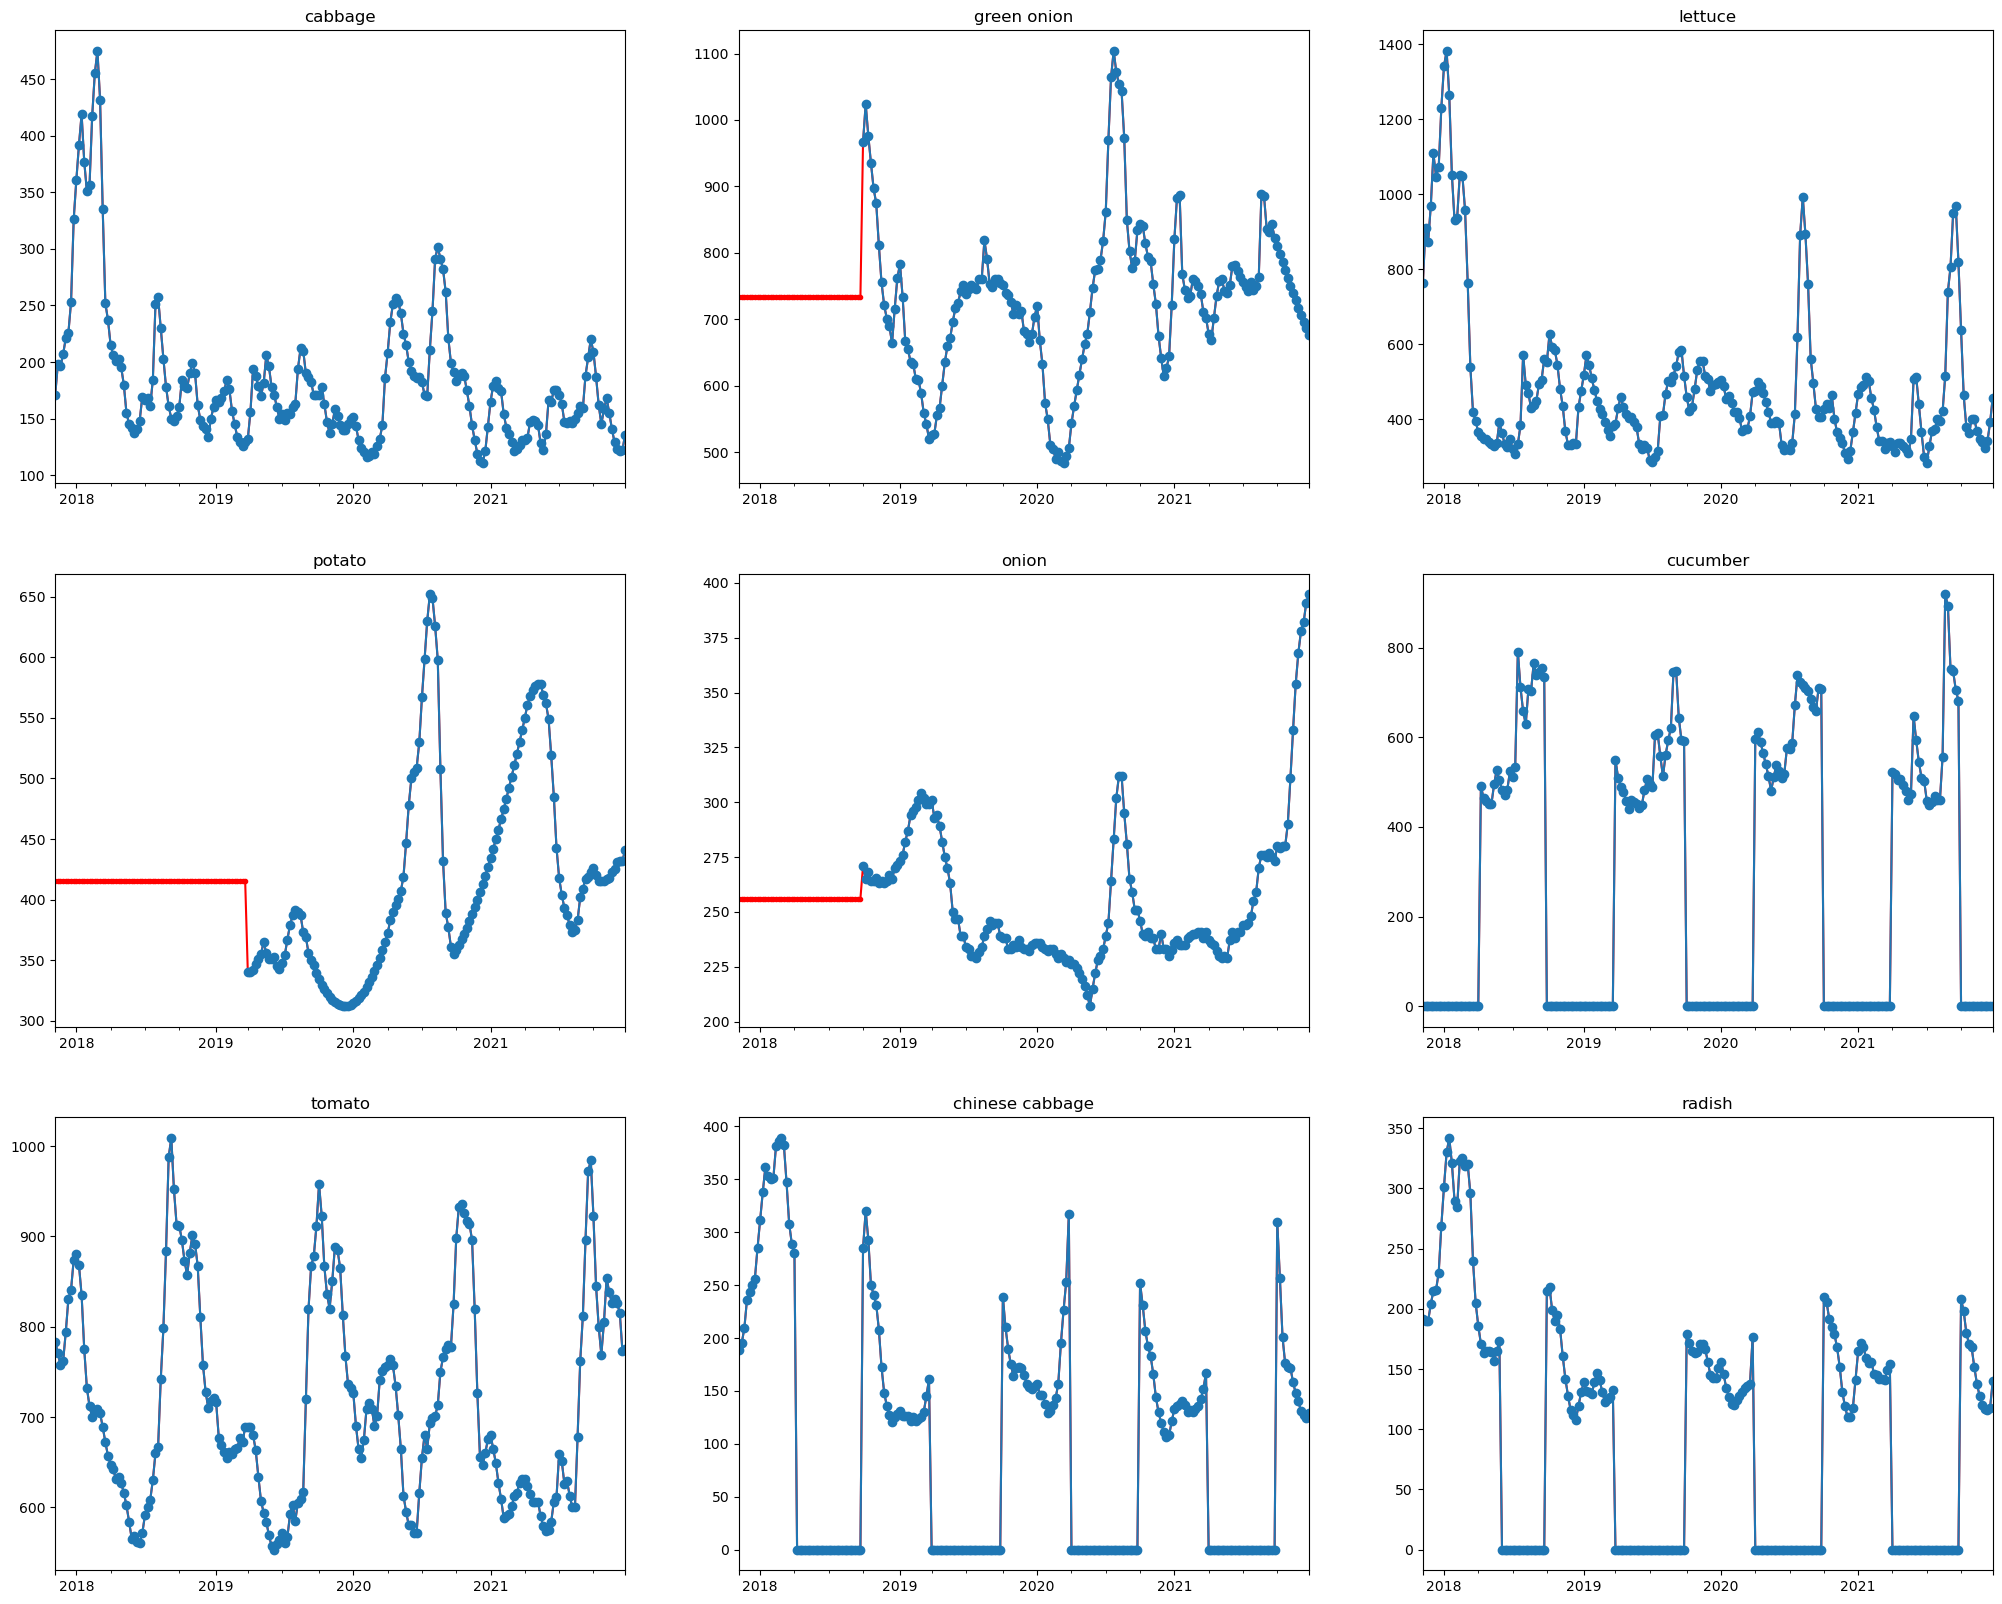

In [42]:
# define figure
plt.figure(figsize=(25,20))
idx = 1

# plot time series for all the columns
for col_name in df.columns:
    plt.subplot(3, 3, idx)
    
    train_df[col_name].plot(color='red', marker='.')
    tmp_df[col_name].plot(marker='o')
    plt.title(col_name)
    
    idx += 1

plt.show()
del tmp_df

<AxesSubplot:>

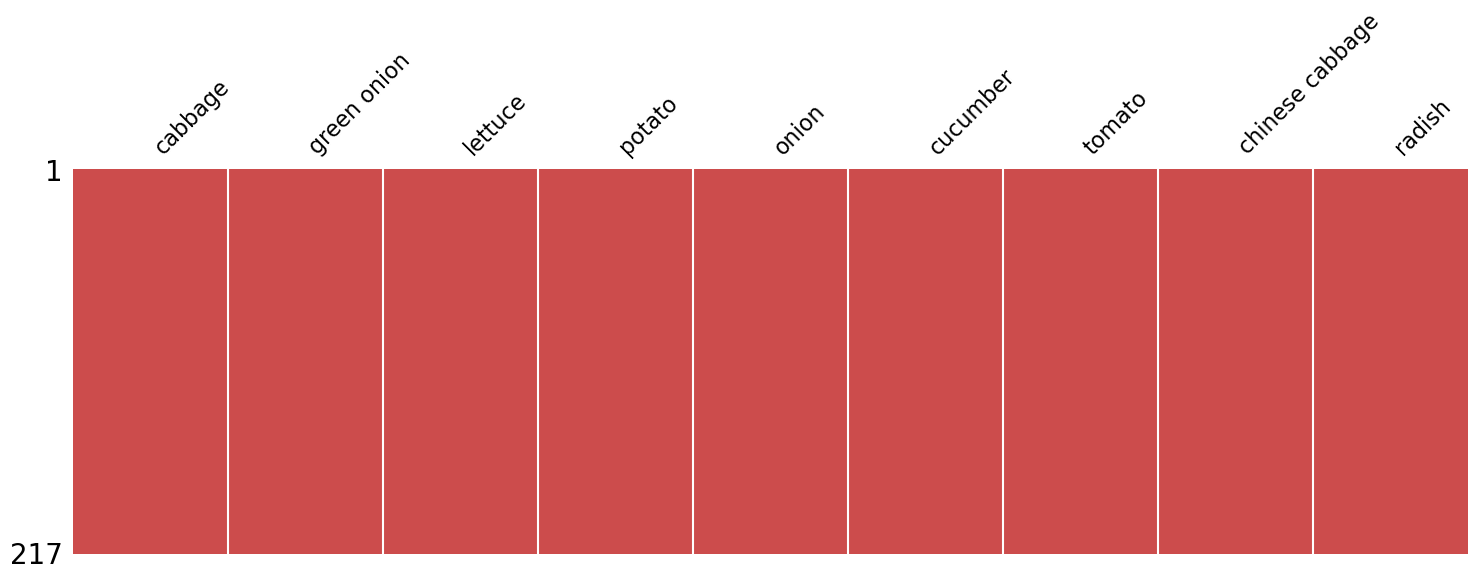

In [43]:
# visualise the pattern of missing data
msno.matrix(train_df, figsize=(18,5), color=(0.8, 0.3, 0.3), sparkline=False)

### Standardizing the features

In [44]:
# define scaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(train_df)

# transform the training and testing dataset
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

# get the column names
col_names = train_df.columns

# build dataframe from the numpy.ndarray returned above
scaled_train_df = pd.DataFrame(data=scaled_train, columns=col_names)
scaled_test_df = pd.DataFrame(data=scaled_test, columns=col_names)

<AxesSubplot:>

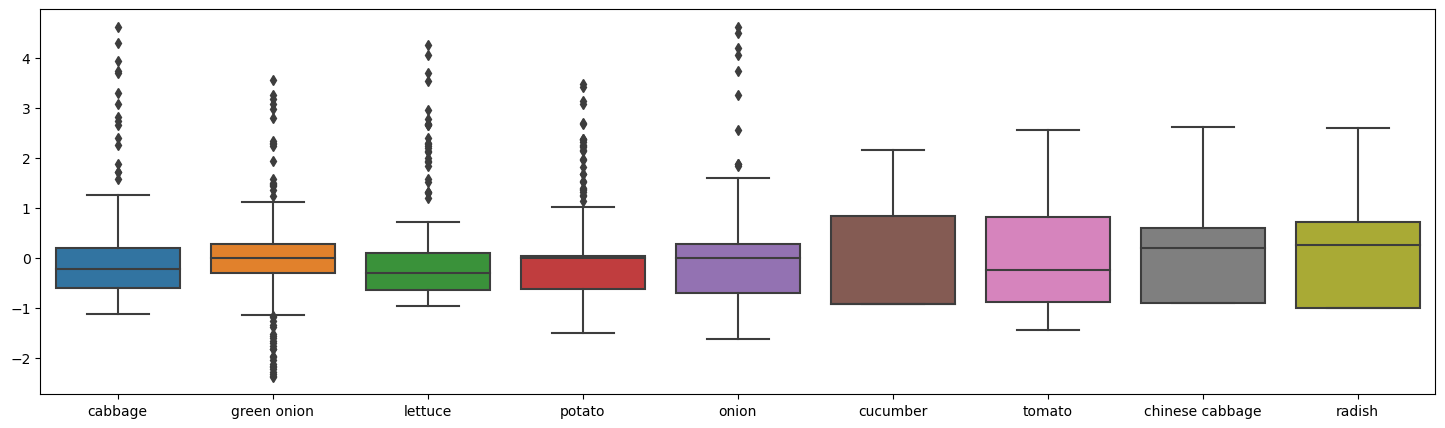

In [45]:
# define figure
plt.figure(figsize=(18,5))

# boxplot for all the columns
sns.boxplot(data=scaled_train_df)

### Transform time series dataset into a supervised learning dataset

As mentioned above, the dataset has to be now transformed before giving it as an input to the Neural Network models.  
For this, the following were considered:
- the model will be trained on previous 20 weeks of data, and
- the model will forecast the price of `cabbage` for the next 8 weeks.

In [46]:
# define function to transform the dataset
def build_supervised_learning_dataset(df_: pd.DataFrame, past: int, future: int) -> pd.DataFrame:
    
    # define range for the loop to build transformed dataset
    range_ = df_.shape[0] - past - future + 1

    # empty lists to be temporarily populated with formatted data
    X_arr = []
    y_arr = []

    # build the independent features
    for i in range(range_):
        X_arr.append(df_.iloc[i:i+past, :].values)
        y_arr.append(df_.iloc[i+past:i+past+future, 0].values)
    
    return X_arr, y_arr

In [47]:
# variables to define number of samples from past and future data
n_steps_in = 20            # number of historical samples to be considered
n_steps_out = 8            # number of sequences in future to be predicted

# get the transformed data
X_train, y_train = build_supervised_learning_dataset(df_=scaled_train_df, past=n_steps_in, future=n_steps_out)

print('Training feature data: ')
print(f'number of features in each record: {len(X_train[0])}')
display(X_train[0])

print('Training target data: ')
print(f'number of target values of each record: {len(y_train[0])}')
display(y_train[:4])

Training feature data: 
number of features in each record: 20


array([[-0.18784369,  0.        ,  1.31003139,  0.        ,  0.        ,
        -0.9272203 ,  0.57433347,  0.8038806 ,  1.02035431],
       [ 0.23957266,  0.        ,  2.0070255 ,  0.        ,  0.        ,
        -0.9272203 ,  0.46899883,  0.85812111,  0.99917193],
       [ 0.20791219,  0.        ,  1.83516394,  0.        ,  0.        ,
        -0.9272203 ,  0.34610841,  0.9846823 ,  0.99917193],
       [ 0.38204477,  0.        ,  2.29346143,  0.        ,  0.        ,
        -0.9272203 ,  0.38999785,  1.22876459,  1.14744862],
       [ 0.60366807,  0.        ,  2.96181195,  0.        ,  0.        ,
        -0.9272203 ,  0.67089023,  1.29204518,  1.26395173],
       [ 0.68281924,  0.        ,  2.66105422,  0.        ,  0.        ,
        -0.9272203 ,  0.99567205,  1.35532577,  1.27454292],
       [ 1.1102356 ,  0.        ,  2.78517645,  0.        ,  0.        ,
        -0.9272203 ,  1.08345092,  1.40956628,  1.42281961],
       [ 2.26584277,  0.        ,  3.53945775,  0.        ,  0

Training target data: 
number of target values of each record: 8


[array([ 0.85695183,  0.50868666,  0.36621454,  0.28706336,  0.31872383,
         0.19716734, -0.04537158, -0.44112746]),
 array([ 0.50868666,  0.36621454,  0.28706336,  0.31872383,  0.19716734,
        -0.04537158, -0.44112746, -0.59942981]),
 array([ 0.36621454,  0.28706336,  0.31872383,  0.19716734, -0.04537158,
        -0.44112746, -0.59942981, -0.64692052]),
 array([ 0.28706336,  0.31872383,  0.19716734, -0.04537158, -0.44112746,
        -0.59942981, -0.64692052, -0.72607169])]

In [48]:
# transform the above list of arrays into proper numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# count of features in each sample per timestep
n_features = X_train.shape[2]

print(f'Dimension of training feature data: {X_train.shape}')
print(f'Dimension of training target data: {y_train.shape}')

Dimension of training feature data: (190, 20, 9)
Dimension of training target data: (190, 8)


In [49]:
# transform the testing data in the desired format
X_test, y_test = build_supervised_learning_dataset(df_=scaled_test_df, past=n_steps_in, future=n_steps_out)

# transform the above list of arrays into proper numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'Dimension of testing feature data: {X_test.shape}')
print(f'Dimension of testing target data: {y_test.shape}')

Dimension of testing feature data: (15, 20, 9)
Dimension of testing target data: (15, 20, 9)


## Model building and forecasting

## 1. Recurrent Neural Network model for forecasting

### Build RNN model to be trained on the transformed data

As shown above, the dataset is now transformed and has the following structure (shape):  
    [`samples`, `timesteps`, `features`]

The RNN model can be built now.

In [50]:
# build RNN model
rnn_model = Sequential()

# add RNN layers
rnn_model.add(layers.SimpleRNN(
    units=5,
    activation='relu',
    input_shape=(n_steps_in, n_features) 
))

# add dropout layer to avoid overfitting
rnn_model.add(layers.Dropout(rate=0.2))

# add a dense layer with the desired number of outputs as the unit
rnn_model.add(layers.Dense(n_steps_out))

# evaluating loss function of MSE using the adam optimiser
rnn_model.compile(optimizer='adam', loss='mse')

# print out the model architecture
rnn_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 75        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 48        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


### Train RNN model on the training data

The above created RNN model is trained on the training data

In [51]:
# fit the model
history = rnn_model.fit(X_train, y_train,
                                shuffle=False,
                                epochs=100,
                                validation_split=0.2,
                                verbose=1)

Train on 152 samples, validate on 38 samples
Epoch 1/100


2023-10-30 20:33:03.170204: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 20:33:03.171822: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


152/152 [==============================] - 2s 11ms/sample - loss: 1.0402 - val_loss: 0.5630
Epoch 2/100
152/152 [==============================] - 0s 488us/sample - loss: 0.9952 - val_loss: 0.5424
Epoch 3/100
152/152 [==============================] - 0s 499us/sample - loss: 0.9582 - val_loss: 0.5239
Epoch 4/100
152/152 [==============================] - 0s 497us/sample - loss: 0.8161 - val_loss: 0.5076
Epoch 5/100
152/152 [==============================] - 0s 485us/sample - loss: 0.8879 - val_loss: 0.4927
Epoch 6/100
152/152 [==============================] - 0s 530us/sample - loss: 0.8377 - val_loss: 0.4792
Epoch 7/100
152/152 [==============================] - 0s 452us/sample - loss: 0.8300 - val_loss: 0.4670
Epoch 8/100
152/152 [==============================] - 0s 456us/sample - loss: 0.7895 - val_loss: 0.4564
Epoch 9/100
152/152 [==============================] - 0s 460us/sample - loss: 0.7574 - val_loss: 0.4462
Epoch 10/100
152/152 [==============================] - 0s 460us/sam

152/152 [==============================] - 0s 475us/sample - loss: 0.3200 - val_loss: 0.2440
Epoch 79/100
152/152 [==============================] - 0s 469us/sample - loss: 0.3348 - val_loss: 0.2435
Epoch 80/100
152/152 [==============================] - 0s 473us/sample - loss: 0.3298 - val_loss: 0.2430
Epoch 81/100
152/152 [==============================] - 0s 461us/sample - loss: 0.3294 - val_loss: 0.2426
Epoch 82/100
152/152 [==============================] - 0s 467us/sample - loss: 0.3247 - val_loss: 0.2425
Epoch 83/100
152/152 [==============================] - 0s 451us/sample - loss: 0.3159 - val_loss: 0.2424
Epoch 84/100
152/152 [==============================] - 0s 458us/sample - loss: 0.3258 - val_loss: 0.2421
Epoch 85/100
152/152 [==============================] - 0s 466us/sample - loss: 0.3154 - val_loss: 0.2421
Epoch 86/100
152/152 [==============================] - 0s 458us/sample - loss: 0.3238 - val_loss: 0.2421
Epoch 87/100
152/152 [==============================] - 0s 

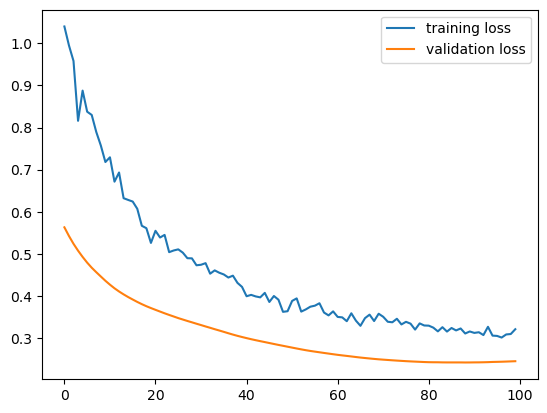

In [52]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### Predict the future values with the trained RNN model

Now, the future values can be predicted with the RNN model trained above

In [53]:
# predict the future values
y_hat = rnn_model.predict(X_test, verbose=0)

In [54]:
# calculate Error metrices
rnn_mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_hat)
rnn_rmse = mean_squared_error(y_true=y_test, y_pred=y_hat, squared=True)

print(f'Mean absolute percentage error: {rnn_mape:.4f}')
print(f'Root Mean Squared error: {rnn_rmse:.4f}')


Mean absolute percentage error: 1.0464
Root Mean Squared error: 0.1669


## 2. Long Short-Term Memory networks for forecasting

### Build LSTM model to be trained on the transformed data

The LSTM model is built now

In [55]:
# build LSTM model
lstm_model = Sequential()

# add LSTM layers
lstm_model.add(layers.LSTM(
    units=5,
    activation='relu',
    input_shape=(n_steps_in, n_features) 
))

# add dropout layer to avoid overfitting
lstm_model.add(layers.Dropout(rate=0.2))

# add a dense layer with the desired number of outputs as the unit
lstm_model.add(layers.Dense(n_steps_out))

# evaluating loss function of MSE using the adam optimiser
lstm_model.compile(optimizer='adam', loss='mse')

# print out the model architecture
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 48        
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________


### Train LSTM model on the training data

The above created LSTM model is trained on the training data

In [56]:
# fit the model
history = lstm_model.fit(X_train, y_train,
                                shuffle=False,
                                epochs=100,
                                validation_split=0.2,
                                verbose=1)

Train on 152 samples, validate on 38 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
152/152 [==============================] - 4s 24ms/sample - loss: 0.6050 - val_loss: 0.6606
Epoch 2/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5699 - val_loss: 0.6296
Epoch 3/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5265 - val_loss: 0.6015
Epoch 4/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5225 - val_loss: 0.5765
Epoch 5/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.4999 - val_loss: 0.5543
Epoch 6/100
152/152 [==============================] - 1s 4ms/sample - loss: 0.4923 - val_loss: 0.5356
Epoch 7/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.4857 - val_loss: 0.5183
Epoch 8/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.4715 - val_loss: 0.5031
Epoch 9/100
152/152 [===============

152/152 [==============================] - 0s 2ms/sample - loss: 0.2962 - val_loss: 0.3880
Epoch 77/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2738 - val_loss: 0.3889
Epoch 78/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2788 - val_loss: 0.3916
Epoch 79/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2873 - val_loss: 0.3949
Epoch 80/100
152/152 [==============================] - 0s 3ms/sample - loss: 0.2854 - val_loss: 0.3977
Epoch 81/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2633 - val_loss: 0.4009
Epoch 82/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2830 - val_loss: 0.4046
Epoch 83/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2766 - val_loss: 0.4074
Epoch 84/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.2923 - val_loss: 0.4097
Epoch 85/100
152/152 [==============================] - 0s 2ms/sample - loss:

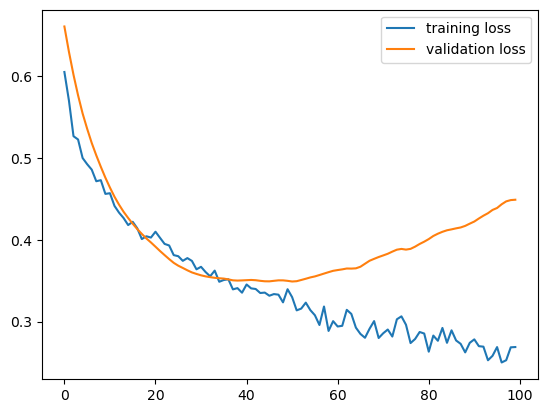

In [57]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### Predict the future values with the trained LSTM model

Now, the future values are predicted with the LSTM model trained above

In [58]:
# predict the future values
y_hat = lstm_model.predict(X_test, verbose=0)

In [59]:
# calculate Error metrices
lstm_mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_hat)
lstm_rmse = mean_squared_error(y_true=y_test, y_pred=y_hat, squared=True)

print(f'Mean absolute percentage error: {lstm_mape:.4f}')
print(f'Root Mean Squared error: {lstm_rmse:.4f}')


Mean absolute percentage error: 10.4995
Root Mean Squared error: 9.5386


## 3. Gated Recurrent Unit networks for forecasting

### Build GRU model to be trained on the transformed data

The GRU model is built now

In [60]:
# build GRU model
gru_model = Sequential()

# add GRU layers
gru_model.add(layers.GRU(
    units=5,
    activation='relu',
    input_shape=(n_steps_in, n_features) 
))

# add dropout layer to avoid overfitting
gru_model.add(layers.Dropout(rate=0.2))

# add a dense layer with the desired number of outputs as the unit
gru_model.add(layers.Dense(n_steps_out))

# evaluating loss function of MSE using the adam optimiser
gru_model.compile(optimizer='adam', loss='mse')

# print out the model architecture
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 225       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 48        
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


### Train GRU model on the training data

The above created GRU model is the trained on the training data

In [61]:
# fit the model
history = gru_model.fit(X_train, y_train,
                                shuffle=False,
                                epochs=100,
                                validation_split=0.2,
                                verbose=1)

Train on 152 samples, validate on 38 samples
Epoch 1/100
152/152 [==============================] - 4s 28ms/sample - loss: 0.6164 - val_loss: 0.4462
Epoch 2/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5598 - val_loss: 0.4391
Epoch 3/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5521 - val_loss: 0.4326
Epoch 4/100
152/152 [==============================] - 0s 3ms/sample - loss: 0.5503 - val_loss: 0.4268
Epoch 5/100
152/152 [==============================] - 0s 3ms/sample - loss: 0.5454 - val_loss: 0.4216
Epoch 6/100
152/152 [==============================] - 0s 3ms/sample - loss: 0.5235 - val_loss: 0.4166
Epoch 7/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.5185 - val_loss: 0.4119
Epoch 8/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.4965 - val_loss: 0.4080
Epoch 9/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.4927 - val_loss: 0.4041
Epoch 10/100
152/152 [=====

152/152 [==============================] - 0s 2ms/sample - loss: 0.3443 - val_loss: 0.3172
Epoch 80/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3275 - val_loss: 0.3176
Epoch 81/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3267 - val_loss: 0.3183
Epoch 82/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3211 - val_loss: 0.3191
Epoch 83/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3152 - val_loss: 0.3198
Epoch 84/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3225 - val_loss: 0.3205
Epoch 85/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3258 - val_loss: 0.3211
Epoch 86/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3082 - val_loss: 0.3220
Epoch 87/100
152/152 [==============================] - 0s 2ms/sample - loss: 0.3304 - val_loss: 0.3230
Epoch 88/100
152/152 [==============================] - 0s 2ms/sample - loss:

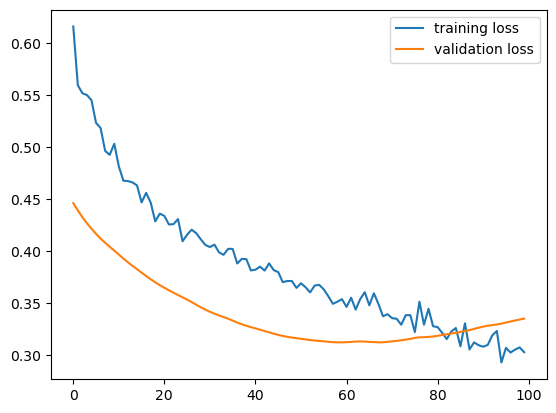

In [62]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### Predict the future values with the trained GRU model

Now, the future values are predicted with the GRU model

In [63]:
# predict the future values
y_hat = gru_model.predict(X_test, verbose=0)

In [64]:
# calculate Error metrices
gru_mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_hat)
gru_rmse = mean_squared_error(y_true=y_test, y_pred=y_hat, squared=True)

print(f'Mean absolute percentage error: {gru_mape:.4f}')
print(f'Root Mean Squared error: {gru_rmse:.4f}')


Mean absolute percentage error: 1.8230
Root Mean Squared error: 0.3594


## Save the trained Neural Network Models

The above trained models are serialised and stored in a file, which can then later be loaded to make new predictions or other analysis.

In [68]:
# save the models
rnn_model.save('rnn_model.keras')
lstm_model.save('lstm_model.keras')
gru_model.save('gru_model.keras')

## Save the transformed training and testing data

The training and testing data in its transformed format is also serialised and stored in a file for later use.

In [69]:
# pickle the training and testing data
pickle.dump(X_train, open('X_train.pickle', 'wb'))
pickle.dump(y_train, open('y_train.pickle', 'wb'))
pickle.dump(X_test, open('X_test.pickle', 'wb'))
pickle.dump(y_test, open('y_test.pickle', 'wb'))

## Save the column names of training and testing data

The column names are used later for the explainer models.

In [70]:
# pickle the training and testing data
pickle.dump(col_names, open('col_names.pickle', 'wb'))

---